In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic


In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 7.8MB/s 
     |████████████████████████████████| 2.1MB 23.2MB/s 
     |████████████████████████████████| 9.5MB 24.6MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
df = pd.read_csv('/content/data_solar.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.drop(df.iloc[:,14:46],inplace= True, axis= 1)
df.columns = df.iloc[1]
df2 = df.drop([0,1])
df2.reset_index()
df2['Date'] = pd.to_datetime(df2[["Year", "Month", "Day", "Hour", "Minute"]])
df2

1      Year Month Day  ... Relative Humidity Temperature                Date
2      2018     1   1  ...             58.63        -2.4 2018-01-01 00:00:00
3      2018     1   1  ...              59.5        -2.6 2018-01-01 00:30:00
4      2018     1   1  ...             57.79        -2.8 2018-01-01 01:00:00
5      2018     1   1  ...             58.65          -3 2018-01-01 01:30:00
6      2018     1   1  ...             57.31        -3.2 2018-01-01 02:00:00
...     ...   ...  ..  ...               ...         ...                 ...
17517  2018    12  31  ...             65.22        -1.3 2018-12-31 21:30:00
17518  2018    12  31  ...             61.94        -1.6 2018-12-31 22:00:00
17519  2018    12  31  ...             62.86        -1.8 2018-12-31 22:30:00
17520  2018    12  31  ...             60.35        -2.1 2018-12-31 23:00:00
17521  2018    12  31  ...             60.79        -2.2 2018-12-31 23:30:00

[17520 rows x 15 columns]

The data is now imported and ready to be worked upon


In [ ]:
df2.Date

2       2018-01-01 00:00:00
3       2018-01-01 00:30:00
4       2018-01-01 01:00:00
5       2018-01-01 01:30:00
6       2018-01-01 02:00:00
                ...        
17517   2018-12-31 21:30:00
17518   2018-12-31 22:00:00
17519   2018-12-31 22:30:00
17520   2018-12-31 23:00:00
17521   2018-12-31 23:30:00
Name: Date, Length: 17520, dtype: datetime64[ns]

In [ ]:
summer_start = df2.index[df2.Date == "2018-06-21 00:00:00"]
summer_end = df2.index[df2.Date == "2018-09-22 23:30:00"]
spring_start = df2.index[df2.Date == "2018-03-21 00:00:00"]
spring_end = df2.index[df2.Date == "2018-06-20 23:30:00"]
autumn_start = df2.index[df2.Date == "2018-09-23 00:00:00"]
autumn_end = df2.index[df2.Date == "2018-12-21 23:30:00"]
winter_start = df2.index[df2.Date == "2018-12-22 00:00:00"]
winter_end = df2.index[df2.Date == "2018-03-20 23:30:00"]

Here the data splits into seasons according to the date and time.

In [ ]:
print(summer_start)
print(summer_end)

Int64Index([8210], dtype='int64')
Int64Index([12721], dtype='int64')


Since this is the code for summer, we find out the onset and summer and when it ends to divide the data accordingly


In [ ]:
df_Summer = df2.iloc[ 8208:12720 , : ]
df_Summer.drop(df_Summer.iloc[:,0:5],inplace= True, axis= 1)
df_Summer_Train = df_Summer.set_index('Date')
Summer = df_Summer_Train[df_Summer_Train.GHI != "0"]
Summer

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1                    DHI  DNI  GHI  ... Wind Direction Relative Humidity Temperature
Date                                ...                                             
2018-06-21 05:30:00    2   10    2  ...             57             98.17        23.6
2018-06-21 06:00:00   26  205   41  ...             57             96.49        23.9
2018-06-21 06:30:00   46  424  119  ...             61              93.1        24.5
2018-06-21 07:00:00   60  567  217  ...             64             88.86        25.1
2018-06-21 07:30:00   69  664  321  ...             69             83.76        26.1
...                  ...  ...  ...  ...            ...               ...         ...
2018-09-22 16:30:00  163   41  181  ...            335             69.94        24.9
2018-09-22 17:00:00   77   11   81  ...            338             71.99        24.2
2018-09-22 17:30:00    7    0    7  ...            338             71.99        24.2
2018-09-22 18:00:00    5    0    5  ...            342              83.1          22
2018-09-22 18:30:00    1    0    1  ...            343             86.81        21.3

[2546 rows x 9 columns]

Here we get rid of all the data reduntant data by hardcoding and using Pandas function, and the date column is made as the index, for the model to have a time-varying index as this will help the model make better forecasts.

Final dataset after data engineering and munging.

In [ ]:
Summer.index

DatetimeIndex(['2018-06-21 05:30:00', '2018-06-21 06:00:00',
               '2018-06-21 06:30:00', '2018-06-21 07:00:00',
               '2018-06-21 07:30:00', '2018-06-21 08:00:00',
               '2018-06-21 08:30:00', '2018-06-21 09:00:00',
               '2018-06-21 09:30:00', '2018-06-21 10:00:00',
               ...
               '2018-09-22 14:00:00', '2018-09-22 14:30:00',
               '2018-09-22 15:00:00', '2018-09-22 15:30:00',
               '2018-09-22 16:00:00', '2018-09-22 16:30:00',
               '2018-09-22 17:00:00', '2018-09-22 17:30:00',
               '2018-09-22 18:00:00', '2018-09-22 18:30:00'],
              dtype='datetime64[ns]', name='Date', length=2546, freq=None)

Dataset's index for the user's reference.

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
DF=Summer
DF.drop(['Surface Albedo'], axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
DF

1                    DHI  DNI   GHI Dew Point Wind Speed Wind Direction  \
Date                                                                      
2018-06-21 05:30:00    2   10     2      23.3        2.6             57   
2018-06-21 06:00:00   26  205    41      23.3        2.9             57   
2018-06-21 06:30:00   46  424   119      23.3        3.1             61   
2018-06-21 07:00:00   60  567   217      23.1        3.3             64   
2018-06-21 07:30:00   69  664   321      23.1        3.4             69   
2018-06-21 08:00:00   76  735   428      22.4        3.6             75   
2018-06-21 08:30:00  131  630   493      22.4        3.6             80   
2018-06-21 09:00:00  249  414   523      21.7        3.6             86   
2018-06-21 09:30:00  323  302   547      21.7        3.6             92   
2018-06-21 10:00:00  376  150   498      21.2        3.5             97   
2018-06-21 10:30:00  421  110   517      21.2        3.6            101   
2018-06-21 11:00:00  461  174   622        21        3.7            106   
2018-06-21 11:30:00  466  141   601        21        3.8            109   
2018-06-21 12:00:00  422   76   497      20.8        3.9            113   
2018-06-21 12:30:00  496  161   656      20.8          4            116   
2018-06-21 13:00:00  488  155   641      20.8        4.1            119   
2018-06-21 13:30:00  473  237   704      20.8        4.1            123   
2018-06-21 14:00:00  469  212   669      20.8        4.2            126   
2018-06-21 14:30:00  414  294   678      20.8        4.1            128   
2018-06-21 15:00:00  395  272   625      20.8        4.1            131   
2018-06-21 15:30:00  358  245   549      20.8        3.9            132   
2018-06-21 16:00:00  299  290   502      20.8        3.8            133   
2018-06-21 16:30:00  224  417   481      20.8        3.6            133   
2018-06-21 17:00:00  213  183   309      20.8        3.4            134   
2018-06-21 17:30:00  161  278   280      20.8        3.4            134   
2018-06-21 18:00:00  100  380   224      20.9          3            135   
2018-06-21 18:30:00   63  318   134      20.9        2.5            137   
2018-06-21 19:00:00   39  246    68      21.8        1.9            140   
2018-06-21 19:30:00   11   53    12      21.8        1.9            143   
2018-06-22 05:30:00    2    6     2      23.3        1.4            200   
2018-06-22 06:00:00   28  165    40      23.3        1.9            202   
2018-06-22 06:30:00   51  391   118      23.3        2.2            203   
2018-06-22 07:00:00   86  199   141      22.6        2.5            205   
2018-06-22 07:30:00   98   47   116      22.6        2.7            205   
2018-06-22 08:00:00   77    0    77      21.3        2.9            206   
2018-06-22 08:30:00  143    6   146      21.3          3            205   
2018-06-22 09:00:00  250   56   287      20.9        3.1            204   
2018-06-22 09:30:00  315  218   477      20.9        3.2            201   
2018-06-22 10:00:00  341  241   537        21        3.2            198   
2018-06-22 10:30:00  242  557   729        21        3.3            195   
2018-06-22 11:00:00  291  520   771      21.1        3.4            191   
2018-06-22 11:30:00  426  291   705      21.1        3.6            188   
2018-06-22 12:00:00  462  227   685      21.1        3.7            185   
2018-06-22 12:30:00  445  177   621      21.1        3.8            183   
2018-06-22 13:00:00  418  266   681        21          4            180   
2018-06-22 13:30:00  373  353   717        21          4            178   
2018-06-22 14:00:00  390  294   667        21        4.1            176   
2018-06-22 14:30:00  349  286   606        21        4.1            174   
2018-06-22 15:00:00  337  234   535      20.9        4.2            172   
2018-06-22 15:30:00  235  531   648      20.9        4.2            170   
2018-06-22 16:00:00  166  646   619        21        4.2            169   
2018-06-22 16:30:00  127 

In [ ]:
df_arima = DF['DHI']
arima = pd.DataFrame(df_arima, index = DF.index)
flarima = pd.DataFrame(arima.DHI.astype(float).resample('H').mean().dropna(), index = arima.index)
fl_arima = flarima.dropna()

Since ARIMA is a univariate model, we only consider the column we need to predict here and convert that we convert to float datatype for plotting it graphically.

In [ ]:
arima

DHI
Date                    
2018-06-21 05:30:00    2
2018-06-21 06:00:00   26
2018-06-21 06:30:00   46
2018-06-21 07:00:00   60
2018-06-21 07:30:00   69
2018-06-21 08:00:00   76
2018-06-21 08:30:00  131
2018-06-21 09:00:00  249
2018-06-21 09:30:00  323
2018-06-21 10:00:00  376
2018-06-21 10:30:00  421
2018-06-21 11:00:00  461
2018-06-21 11:30:00  466
2018-06-21 12:00:00  422
2018-06-21 12:30:00  496
2018-06-21 13:00:00  488
2018-06-21 13:30:00  473
2018-06-21 14:00:00  469
2018-06-21 14:30:00  414
2018-06-21 15:00:00  395
2018-06-21 15:30:00  358
2018-06-21 16:00:00  299
2018-06-21 16:30:00  224
2018-06-21 17:00:00  213
2018-06-21 17:30:00  161
2018-06-21 18:00:00  100
2018-06-21 18:30:00   63
2018-06-21 19:00:00   39
2018-06-21 19:30:00   11
2018-06-22 05:30:00    2
2018-06-22 06:00:00   28
2018-06-22 06:30:00   51
2018-06-22 07:00:00   86
2018-06-22 07:30:00   98
2018-06-22 08:00:00   77
2018-06-22 08:30:00  143
2018-06-22 09:00:00  250
2018-06-22 09:30:00  315
2018-06-22 10:00:00  341
2018-06-22 10:30:00  242
2018-06-22 11:00:00  291
2018-06-22 11:30:00  426
2018-06-22 12:00:00  462
2018-06-22 12:30:00  445
2018-06-22 13:00:00  418
2018-06-22 13:30:00  373
2018-06-22 14:00:00  390
2018-06-22 14:30:00  349
2018-06-22 15:00:00  337
2018-06-22 15:30:00  235
2018-06-22 16:00:00  166
2018-06-22 16:30:00  127
2018-06-22 17:00:00  142
2018-06-22 17:30:00  126
2018-06-22 18:00:00   92
2018-06-22 18:30:00   73
2018-06-22 19:00:00   45
2018-06-22 19:30:00   10
2018-06-23 05:30:00    2
2018-06-23 06:00:00   27
2018-06-23 06:30:00   45
2018-06-23 07:00:00   86
2018-06-23 07:30:00  149
2018-06-23 08:00:00  107
2018-06-23 08:30:00   85
2018-06-23 09:00:00   89
2018-06-23 09:30:00   93
2018-06-23 10:00:00   97
2018-06-23 10:30:00  100
2018-06-23 11:00:00  103
2018-06-23 11:30:00  105
2018-06-23 12:00:00  107
2018-06-23 12:30:00  108
2018-06-23 13:00:00  109
2018-06-23 13:30:00  110
2018-06-23 14:00:00  122
2018-06-23 14:30:00  166
2018-06-23 15:00:00  108
2018-06-23 15:30:00  116
2018-06-23 16:00:00  112
2018-06-23 16:30:00   99
2018-06-23 17:00:00   94
2018-06-23 17:30:00   85
2018-06-23 18:00:00   76
2018-06-23 18:30:00   64
2018-06-23 19:00:00   43
2018-06-23 19:30:00   11
2018-06-24 05:30:00    1
2018-06-24 06:00:00   18
2018-06-24 06:30:00   38
2018-06-24 07:00:00   70
2018-06-24 07:30:00  143
2018-06-24 08:00:00  194
2018-06-24 08:30:00  227
2018-06-24 09:00:00  206
2018-06-24 09:30:00  132
2018-06-24 10:00:00  132
2018-06-24 10:30:00  113
2018-06-24 11:00:00  136
2018-06-24 11:30:00  109
2018-06-24 12:00:00  113
2018-06-24 12:30:00  136
2018-06-24 13:00:00  170
2018-06-24 13:30:00  255
2018-06-24 14:00:00  396
2018-06-24 14:30:00  296
2018-06-24 15:00:00  179
2018-06-24 15:30:00  192
2018-06-24 16:00:00  113
2018-06-24 16:30:00  147
2018-06-24 17:00:00  144
2018-06-24 17:30:00  119
2018-06-24 18:00:00   80
2018-06-24 18:30:00   58
2018-06-24 19:00:00   40
2018-06-24 19:30:00   13
2018-06-25 05:30:00    2
2018-06-25 06:00:00   25
2018-06-25 06:30:00   52
2018-06-25 07:00:00   81
2018-06-25 07:30:00   76
2018-06-25 08:00:00  101
2018-06-25 08:30:00  122
2018-06-25 09:00:00  219
2018-06-25 09:30:00  260
2018-06-25 10:00:00  222
2018-06-25 10:30:00  167
2018-06-25 11:00:00  215
2018-06-25 11:30:00  291
2018-06-25 12:00:00  395
2018-06-25 12:30:00  278
2018-06-25 13:00:00  460
2018-06-25 13:30:00  443
2018-06-25 14:00:00  448
2018-06-25 14:30:00  414
2018-06-25 15:00:00  392
2018-06-25 15:30:00  345
2018-06-25 16:00:00  290
2018-06-25 16:30:00  265
2018-06-25 17:00:00  205
2018-06-25 17:30:00  110
2018-06-25 18:00:00   74
2018-06-25 18:30:00   65
2018-06-25 19:00:00   40
2018-06-25 19:30:00   11
2018-06-26 05:30:00    1
2018-06-26 06:00:00   20
2018-06-26 06:30:00   51
2018-06-26 07:00:00   74
2018-06-26 07:30:00  118
2018-06-26 08:00:00  160
2018-06-26 08:30:00  236
2018-06-26 09:00:00  256
2018-06-26 09:30:00  335
2018-06-26 10:00:00  387
2018-06-26 10:30:00  339
2018-06-26 11:00:00  286
2018-06-26 11:30:00  214
2018-06-26 12:00:00  

In [ ]:
fl_arima

DHI
Date                      
2018-06-21 06:00:00   36.0
2018-06-21 07:00:00   64.5
2018-06-21 08:00:00  103.5
2018-06-21 09:00:00  286.0
2018-06-21 10:00:00  398.5
2018-06-21 11:00:00  463.5
2018-06-21 12:00:00  459.0
2018-06-21 13:00:00  480.5
2018-06-21 14:00:00  441.5
2018-06-21 15:00:00  376.5
2018-06-21 16:00:00  261.5
2018-06-21 17:00:00  187.0
2018-06-21 18:00:00   81.5
2018-06-21 19:00:00   25.0
2018-06-22 06:00:00   39.5
2018-06-22 07:00:00   92.0
2018-06-22 08:00:00  110.0
2018-06-22 09:00:00  282.5
2018-06-22 10:00:00  291.5
2018-06-22 11:00:00  358.5
2018-06-22 12:00:00  453.5
2018-06-22 13:00:00  395.5
2018-06-22 14:00:00  369.5
2018-06-22 15:00:00  286.0
2018-06-22 16:00:00  146.5
2018-06-22 17:00:00  134.0
2018-06-22 18:00:00   82.5
2018-06-22 19:00:00   27.5
2018-06-23 06:00:00   36.0
2018-06-23 07:00:00  117.5
2018-06-23 08:00:00   96.0
2018-06-23 09:00:00   91.0
2018-06-23 10:00:00   98.5
2018-06-23 11:00:00  104.0
2018-06-23 12:00:00  107.5
2018-06-23 13:00:00  109.5
2018-06-23 14:00:00  144.0
2018-06-23 15:00:00  112.0
2018-06-23 16:00:00  105.5
2018-06-23 17:00:00   89.5
2018-06-23 18:00:00   70.0
2018-06-23 19:00:00   27.0
2018-06-24 06:00:00   28.0
2018-06-24 07:00:00  106.5
2018-06-24 08:00:00  210.5
2018-06-24 09:00:00  169.0
2018-06-24 10:00:00  122.5
2018-06-24 11:00:00  122.5
2018-06-24 12:00:00  124.5
2018-06-24 13:00:00  212.5
2018-06-24 14:00:00  346.0
2018-06-24 15:00:00  185.5
2018-06-24 16:00:00  130.0
2018-06-24 17:00:00  131.5
2018-06-24 18:00:00   69.0
2018-06-24 19:00:00   26.5
2018-06-25 06:00:00   38.5
2018-06-25 07:00:00   78.5
2018-06-25 08:00:00  111.5
2018-06-25 09:00:00  239.5
2018-06-25 10:00:00  194.5
2018-06-25 11:00:00  253.0
2018-06-25 12:00:00  336.5
2018-06-25 13:00:00  451.5
2018-06-25 14:00:00  431.0
2018-06-25 15:00:00  368.5
2018-06-25 16:00:00  277.5
2018-06-25 17:00:00  157.5
2018-06-25 18:00:00   69.5
2018-06-25 19:00:00   25.5
2018-06-26 06:00:00   35.5
2018-06-26 07:00:00   96.0
2018-06-26 08:00:00  198.0
2018-06-26 09:00:00  295.5
2018-06-26 10:00:00  363.0
2018-06-26 11:00:00  250.0
2018-06-26 12:00:00  390.0
2018-06-26 13:00:00  353.5
2018-06-26 14:00:00  436.0
2018-06-26 15:00:00  283.0
2018-06-26 16:00:00  133.5
2018-06-26 17:00:00   92.0
2018-06-26 18:00:00   68.5
2018-06-26 19:00:00   26.0
2018-06-27 06:00:00   34.5
2018-06-27 07:00:00   73.5
2018-06-27 08:00:00  209.5
2018-06-27 09:00:00  229.5
2018-06-27 10:00:00   93.0
2018-06-27 11:00:00   99.0
2018-06-27 12:00:00  109.5
2018-06-27 13:00:00  110.0
2018-06-27 14:00:00  108.0
2018-06-27 15:00:00  101.5
2018-06-27 16:00:00   93.5
2018-06-27 17:00:00   93.0
2018-06-27 18:00:00   60.5
2018-06-27 19:00:00   24.5
2018-06-28 06:00:00   32.5
2018-06-28 07:00:00   88.0
2018-06-28 08:00:00  152.0
2018-06-28 09:00:00   82.5
2018-06-28 10:00:00   88.5
2018-06-28 11:00:00   91.0
2018-06-28 12:00:00   97.0
2018-06-28 13:00:00  102.5
2018-06-28 14:00:00   92.5
2018-06-28 15:00:00  104.5
2018-06-28 16:00:00   97.5
2018-06-28 17:00:00   86.5
2018-06-28 18:00:00   67.0
2018-06-28 19:00:00   26.5
2018-06-29 06:00:00   38.0
2018-06-29 07:00:00   73.0
2018-06-29 08:00:00  201.5
2018-06-29 09:00:00  267.5
2018-06-29 10:00:00  167.0
2018-06-29 11:00:00  238.0
2018-06-29 12:00:00  281.5
2018-06-29 13:00:00  184.5
2018-06-29 14:00:00  181.5
2018-06-29 15:00:00  187.5
2018-06-29 16:00:00  163.5
2018-06-29 17:00:00  137.0
2018-06-29 18:00:00   97.5
2018-06-29 19:00:00   30.0
2018-06-30 06:00:00   24.5
2018-06-30 07:00:00  115.5
2018-06-30 08:00:00  209.0
2018-06-30 09:00:00  299.5
2018-06-30 10:00:00  344.5
2018-06-30 11:00:00  437.0
2018-06-30 12:00:00  474.5
2018-06-30 13:00:00  379.0
2018-06-30 14:00:00  206.5
2018-06-30 15:00:00  159.5
2018-06-30 16:00:00  144.0
2018-06-30 17:00:00  124.0
2018-06-30 18:00:00   90.5
2018-06-30 19:00:00   30.5
2018-07-01 06:00:00   46.0
2018-07-01 07:00:00   48.0
2018-07-01 08:00:00  181.0
2018-07-01 09:00:00  186.0
2018-07-01 10:00:00  161.5
2018-07-01 11:00:00  173.0
2018-07-01 12:00:00  198.5


The environment for ARIMA is set using the following libraries.

Our univariate graph before model implementation.

     |████████████████████████████████| 1.5MB 3.3MB/s 
     |████████████████████████████████| 808kB 18.5MB/s 
     |████████████████████████████████| 2.1MB 25.5MB/s 
     |████████████████████████████████| 8.7MB 10.6MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 50.3.2
    Uninstalling setuptools-50.3.2:
      Successfully uninstalled setuptools-50.3.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


Akaike Information Critera (AIC) will quantify, the goodness of fit
and the simplicity/parsimony of the model into a single statistic.
This step provides the mean for model selection. AIC estimates the relative amount of information lost by a given model. It also deals with both the risk of overfitting and the risk of underfitting.
So the order number with the least AIC is considered better, hence the order number with the least AIC is chosen, for the best model selection.

The standardized residual can be interpreted as any standard score.
They are useful in helping to interpret chi-square
tables by providing information about which cells contribute to a significant chi-square. If the standardized residual is beyond the range of ± 2, then that cell is considered to be a major contributor.

The Q-Q plot, or quantile-quantile plot, is a graphical tool to help us assess if a set of data plausibly came from some theoretical distribution such as a Normal in our case.

Correlogram gives a summary of correlation at different periods of time. Also called Auto Correlation Function ACF Plot, is a visual way to show serial correlation. Serial correlation is where an error at one point in time travels to a subsequent point in time.

Kernel density estimation (KDE) is a non-parametric way to estimate the probability density function (PDF) of a random variable.
It uses Gaussian Kernels


In [ ]:
fl_arima

DHI
Date                      
2018-06-21 06:00:00   36.0
2018-06-21 07:00:00   64.5
2018-06-21 08:00:00  103.5
2018-06-21 09:00:00  286.0
2018-06-21 10:00:00  398.5
2018-06-21 11:00:00  463.5
2018-06-21 12:00:00  459.0
2018-06-21 13:00:00  480.5
2018-06-21 14:00:00  441.5
2018-06-21 15:00:00  376.5
2018-06-21 16:00:00  261.5
2018-06-21 17:00:00  187.0
2018-06-21 18:00:00   81.5
2018-06-21 19:00:00   25.0
2018-06-22 06:00:00   39.5
2018-06-22 07:00:00   92.0
2018-06-22 08:00:00  110.0
2018-06-22 09:00:00  282.5
2018-06-22 10:00:00  291.5
2018-06-22 11:00:00  358.5
2018-06-22 12:00:00  453.5
2018-06-22 13:00:00  395.5
2018-06-22 14:00:00  369.5
2018-06-22 15:00:00  286.0
2018-06-22 16:00:00  146.5
2018-06-22 17:00:00  134.0
2018-06-22 18:00:00   82.5
2018-06-22 19:00:00   27.5
2018-06-23 06:00:00   36.0
2018-06-23 07:00:00  117.5
2018-06-23 08:00:00   96.0
2018-06-23 09:00:00   91.0
2018-06-23 10:00:00   98.5
2018-06-23 11:00:00  104.0
2018-06-23 12:00:00  107.5
2018-06-23 13:00:00  109.5
2018-06-23 14:00:00  144.0
2018-06-23 15:00:00  112.0
2018-06-23 16:00:00  105.5
2018-06-23 17:00:00   89.5
2018-06-23 18:00:00   70.0
2018-06-23 19:00:00   27.0
2018-06-24 06:00:00   28.0
2018-06-24 07:00:00  106.5
2018-06-24 08:00:00  210.5
2018-06-24 09:00:00  169.0
2018-06-24 10:00:00  122.5
2018-06-24 11:00:00  122.5
2018-06-24 12:00:00  124.5
2018-06-24 13:00:00  212.5
2018-06-24 14:00:00  346.0
2018-06-24 15:00:00  185.5
2018-06-24 16:00:00  130.0
2018-06-24 17:00:00  131.5
2018-06-24 18:00:00   69.0
2018-06-24 19:00:00   26.5
2018-06-25 06:00:00   38.5
2018-06-25 07:00:00   78.5
2018-06-25 08:00:00  111.5
2018-06-25 09:00:00  239.5
2018-06-25 10:00:00  194.5
2018-06-25 11:00:00  253.0
2018-06-25 12:00:00  336.5
2018-06-25 13:00:00  451.5
2018-06-25 14:00:00  431.0
2018-06-25 15:00:00  368.5
2018-06-25 16:00:00  277.5
2018-06-25 17:00:00  157.5
2018-06-25 18:00:00   69.5
2018-06-25 19:00:00   25.5
2018-06-26 06:00:00   35.5
2018-06-26 07:00:00   96.0
2018-06-26 08:00:00  198.0
2018-06-26 09:00:00  295.5
2018-06-26 10:00:00  363.0
2018-06-26 11:00:00  250.0
2018-06-26 12:00:00  390.0
2018-06-26 13:00:00  353.5
2018-06-26 14:00:00  436.0
2018-06-26 15:00:00  283.0
2018-06-26 16:00:00  133.5
2018-06-26 17:00:00   92.0
2018-06-26 18:00:00   68.5
2018-06-26 19:00:00   26.0
2018-06-27 06:00:00   34.5
2018-06-27 07:00:00   73.5
2018-06-27 08:00:00  209.5
2018-06-27 09:00:00  229.5
2018-06-27 10:00:00   93.0
2018-06-27 11:00:00   99.0
2018-06-27 12:00:00  109.5
2018-06-27 13:00:00  110.0
2018-06-27 14:00:00  108.0
2018-06-27 15:00:00  101.5
2018-06-27 16:00:00   93.5
2018-06-27 17:00:00   93.0
2018-06-27 18:00:00   60.5
2018-06-27 19:00:00   24.5
2018-06-28 06:00:00   32.5
2018-06-28 07:00:00   88.0
2018-06-28 08:00:00  152.0
2018-06-28 09:00:00   82.5
2018-06-28 10:00:00   88.5
2018-06-28 11:00:00   91.0
2018-06-28 12:00:00   97.0
2018-06-28 13:00:00  102.5
2018-06-28 14:00:00   92.5
2018-06-28 15:00:00  104.5
2018-06-28 16:00:00   97.5
2018-06-28 17:00:00   86.5
2018-06-28 18:00:00   67.0
2018-06-28 19:00:00   26.5
2018-06-29 06:00:00   38.0
2018-06-29 07:00:00   73.0
2018-06-29 08:00:00  201.5
2018-06-29 09:00:00  267.5
2018-06-29 10:00:00  167.0
2018-06-29 11:00:00  238.0
2018-06-29 12:00:00  281.5
2018-06-29 13:00:00  184.5
2018-06-29 14:00:00  181.5
2018-06-29 15:00:00  187.5
2018-06-29 16:00:00  163.5
2018-06-29 17:00:00  137.0
2018-06-29 18:00:00   97.5
2018-06-29 19:00:00   30.0
2018-06-30 06:00:00   24.5
2018-06-30 07:00:00  115.5
2018-06-30 08:00:00  209.0
2018-06-30 09:00:00  299.5
2018-06-30 10:00:00  344.5
2018-06-30 11:00:00  437.0
2018-06-30 12:00:00  474.5
2018-06-30 13:00:00  379.0
2018-06-30 14:00:00  206.5
2018-06-30 15:00:00  159.5
2018-06-30 16:00:00  144.0
2018-06-30 17:00:00  124.0
2018-06-30 18:00:00   90.5
2018-06-30 19:00:00   30.5
2018-07-01 06:00:00   46.0
2018-07-01 07:00:00   48.0
2018-07-01 08:00:00  181.0
2018-07-01 09:00:00  186.0
2018-07-01 10:00:00  161.5
2018-07-01 11:00:00  173.0
2018-07-01 12:00:00  198.5


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [ ]:

fl_arima.index

DatetimeIndex(['2018-06-21 06:00:00', '2018-06-21 07:00:00',
               '2018-06-21 08:00:00', '2018-06-21 09:00:00',
               '2018-06-21 10:00:00', '2018-06-21 11:00:00',
               '2018-06-21 12:00:00', '2018-06-21 13:00:00',
               '2018-06-21 14:00:00', '2018-06-21 15:00:00',
               ...
               '2018-09-22 09:00:00', '2018-09-22 10:00:00',
               '2018-09-22 11:00:00', '2018-09-22 12:00:00',
               '2018-09-22 13:00:00', '2018-09-22 14:00:00',
               '2018-09-22 15:00:00', '2018-09-22 16:00:00',
               '2018-09-22 17:00:00', '2018-09-22 18:00:00'],
              dtype='datetime64[ns]', name='Date', length=1269, freq=None)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(fl_arima, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=13978.604, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16766.405, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=14059.137, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=15498.357, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=13954.900, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=13959.619, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=13955.369, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=13954.181, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=13961.528, Time=0.33 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=13723.327, Time=1.68 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=13783.187, Time=0.96 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=13950.805, Time=0.74 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.88 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 8.338 seconds
               

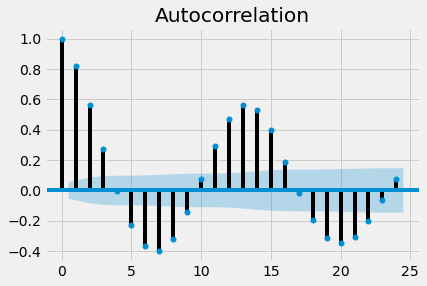

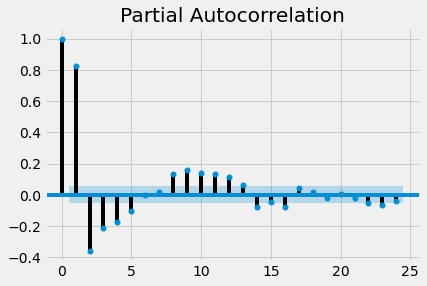

In [ ]:
import pandas as pd
from statsmodels.graphics import tsaplots
plt.style.use('fivethirtyeight')

fig = tsaplots.plot_acf(fl_arima, lags=24)
plt.show()

# Display the partial autocorrelation plot of your time series
fig = tsaplots.plot_pacf(fl_arima, lags=24)
plt.show()

In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.



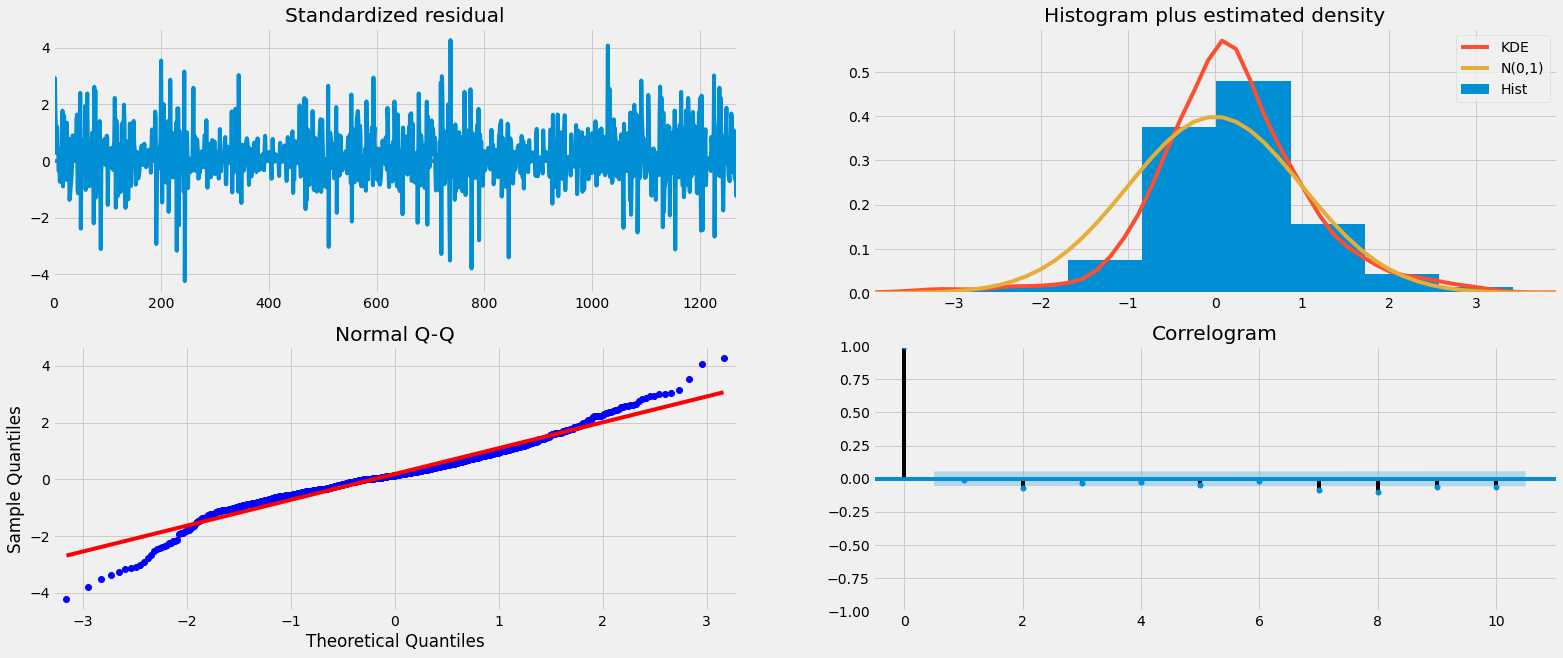

In [ ]:
model.plot_diagnostics(figsize=(24,10))
plt.show()

In [ ]:
lasttwodays = fl_arima['2018-09-22 07:00:00':'2018-09-22 18:00:00']
lasttwodays.at['2018-09-22 07:00:00'] = 41.0
lasttwodays.iloc[:,0]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc[index, col] = value


Date
2018-09-22 07:00:00    41.0 
2018-09-22 08:00:00    137.0
2018-09-22 09:00:00    258.0
2018-09-22 10:00:00    335.0
2018-09-22 11:00:00    342.0
2018-09-22 12:00:00    344.0
2018-09-22 13:00:00    396.5
2018-09-22 14:00:00    333.0
2018-09-22 15:00:00    243.0
2018-09-22 16:00:00    171.5
2018-09-22 17:00:00    42.0 
2018-09-22 18:00:00    3.0  
Name: DHI, dtype: float64

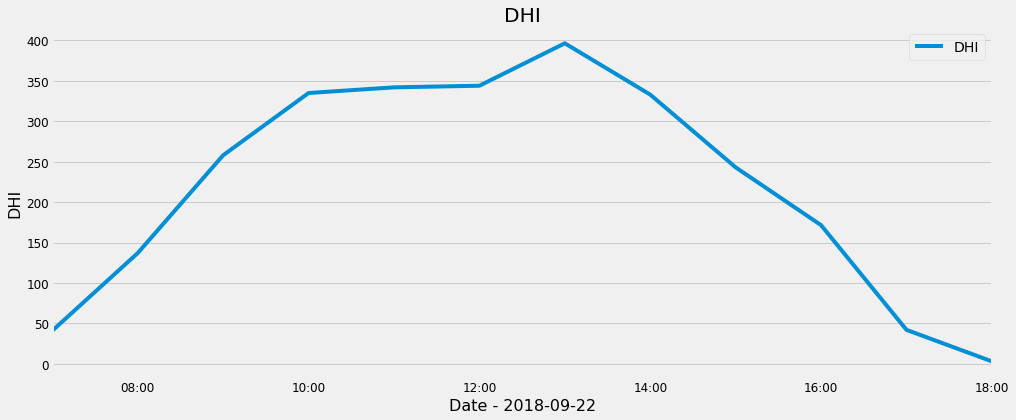

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
import matplotlib
import fbprophet as prophet
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
lasttwodays.plot(figsize=(15, 6))
plt.title("DHI")
plt.xlabel('Date - 2018-09-22', fontsize=16)
plt.ylabel('DHI', fontsize=16)
plt.show()


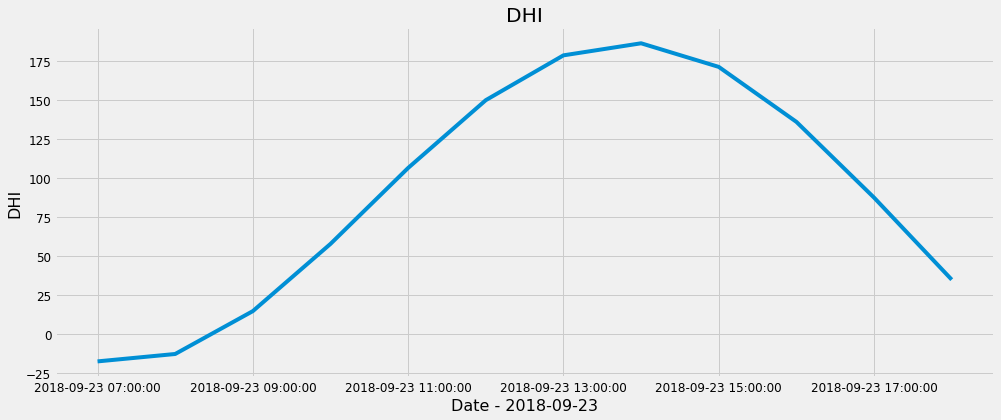

In [ ]:


n_periods = 12
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc =    ['2018-09-23 07:00:00', '2018-09-23 08:00:00',
                  '2018-09-23 09:00:00', '2018-09-23 10:00:00',
                  '2018-09-23 11:00:00', '2018-09-23 12:00:00',
                  '2018-09-23 13:00:00', '2018-09-23 14:00:00',
                  '2018-09-23 15:00:00', '2018-09-23 16:00:00',
                  '2018-09-23 17:00:00', '2018-09-23 18:00:00',]
                  #'2018-09-24 07:00:00', '2018-09-24 08:00:00',
                  #'2018-09-24 09:00:00', '2018-09-24 10:00:00',
                  #'2018-09-24 11:00:00', '2018-09-24 12:00:00',
                  #'2018-09-24 13:00:00', '2018-09-24 14:00:00',
                  #'2018-09-24 15:00:00', '2018-09-24 16:00:00',
                  #'2018-09-24 17:00:00', '2018-09-24 18:00:00',]

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
#plt.plot(fl_arima)
#plt.plot(fc_series, color='darkgreen')
#plt.fill_between(lower_series.index,
#                lower_series,
#                upper_series,
#                color='r', alpha=.05)




import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
import matplotlib
import fbprophet as prophet
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
fc_series.plot(figsize=(15, 6))
plt.title("DHI")
plt.xlabel('Date - 2018-09-23', fontsize=16)
plt.ylabel('DHI', fontsize=16)
plt.show()


In [ ]:
fc_series

2018-09-23 07:00:00   -17.735014 
2018-09-23 08:00:00   -12.979000 
2018-09-23 09:00:00    14.552081 
2018-09-23 10:00:00    57.721515 
2018-09-23 11:00:00    106.497939
2018-09-23 12:00:00    150.023639
2018-09-23 13:00:00    178.799215
2018-09-23 14:00:00    186.545591
2018-09-23 15:00:00    171.379140
2018-09-23 16:00:00    136.081473
2018-09-23 17:00:00    87.431376 
2018-09-23 18:00:00    34.754439 
dtype: float64

OLD APPROACH TO ARIMA
Below


In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import fbprophet as prophet
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

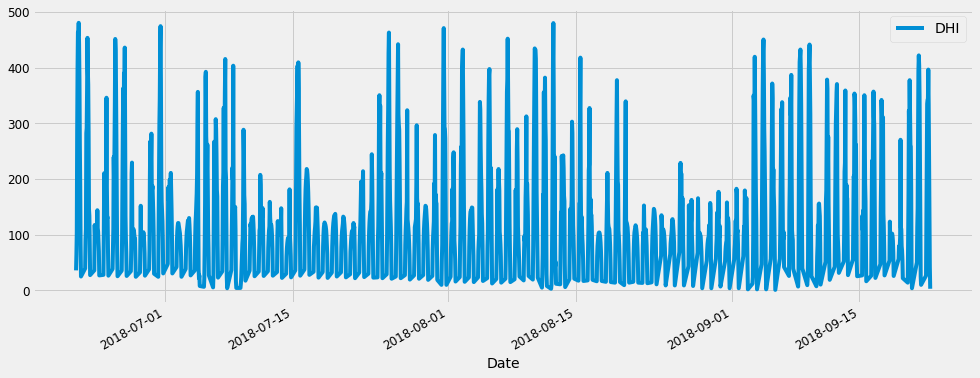

In [ ]:
fl_arima.plot(figsize=(15, 6))
plt.show()

In [ ]:
#from pylab import rcParams
#rcParams['figure.figsize'] = 18, 8
#decomposition = sm.tsa.seasonal_decompose(fl)
#fig = decomposition.plot()
#plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(fl_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:16754.15348931439
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:15774.393596961661
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:15266.554027152746
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:15043.510916430614
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:15154.603610614746
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:15142.943424763187
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:15106.587970946495
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:14779.880398735608
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:15475.232777921363
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:14835.174442184192
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:14576.441245497184
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:14136.307189545603
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:14425.046168560366
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:14279.941461714465
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:14367.123354205909
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:14004.322036567968
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:14073.792738205968
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:13867.389935

In [ ]:

mod = sm.tsa.statespace.SARIMAX(fl_arima,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                DHI   No. Observations:                 1269
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -6778.587
Date:                            Mon, 09 Nov 2020   AIC                          13567.175
Time:                                    12:36:46   BIC                          13592.801
Sample:                                         0   HQIC                         13576.811
                                           - 1269                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7178      0.021     33.895      0.000       0.676       0.759
ma.L1          0.2409      0.026   

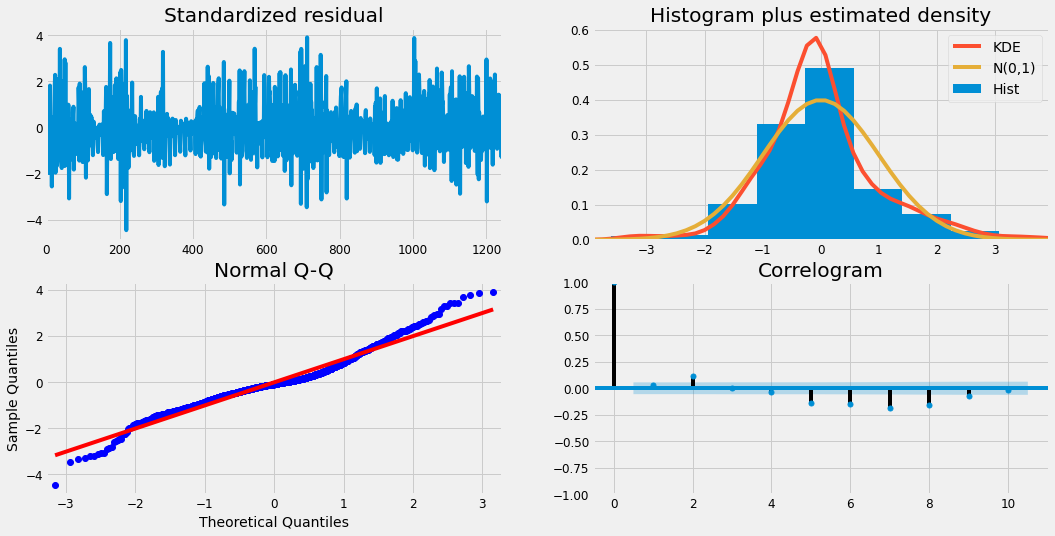

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

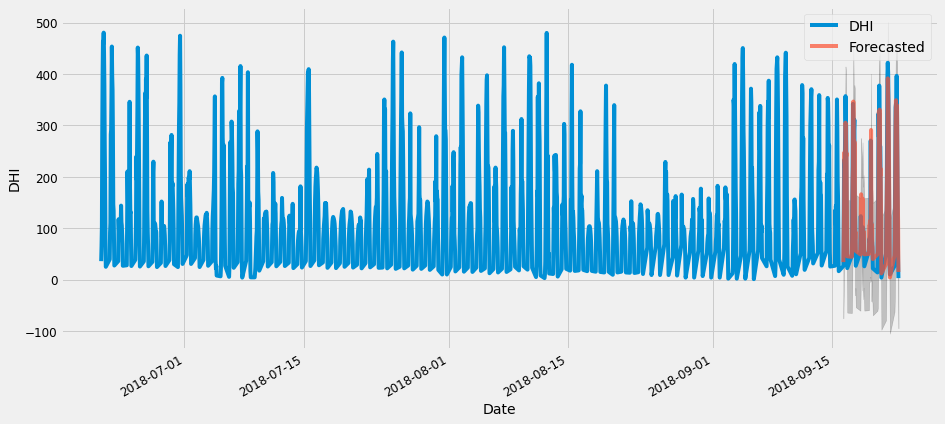

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2018-09-16 07:00:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = fl_arima['2018':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecasted', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('DHI')
plt.legend()
plt.show()

In [ ]:
fl_arima_forecasted = pred.predicted_mean
fl_arima_truth = fl_arima['2018-09-16 07:00:00':]
diff = fl_arima_forecasted.iloc[:,0] - fl_arima_truth.iloc[:,0]
mse = ((diff) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 4)))
mape = ((diff/fl_arima_truth.iloc[:,0])*100).abs().mean()
print('The MAPE of our forecast is {}'.format(round(mape, 4)))


IndexingError: ignored

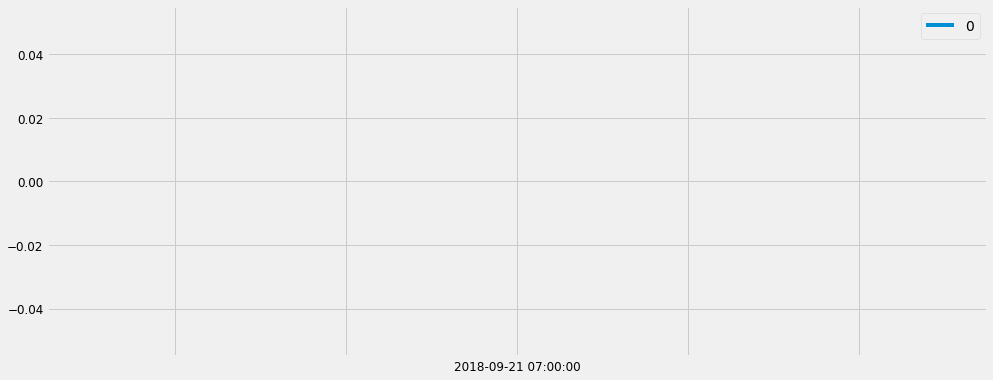

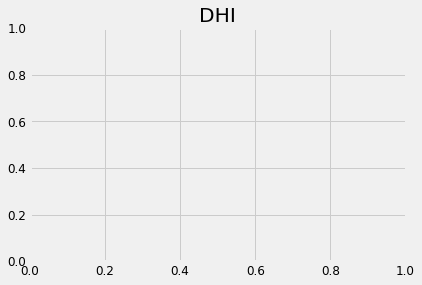

In [ ]:
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
pred_ci.index =  ['2018-09-21 07:00:00', '2018-09-21 08:00:00',
                  '2018-09-21 09:00:00', '2018-09-21 10:00:00',
                  '2018-09-21 11:00:00', '2018-09-21 12:00:00',
                  '2018-09-21 13:00:00', '2018-09-21 14:00:00',
                  '2018-09-21 15:00:00', '2018-09-21 16:00:00',
                  '2018-09-21 17:00:00', '2018-09-21 18:00:00',
                  '2018-09-22 07:00:00', '2018-09-22 08:00:00',
                  '2018-09-22 09:00:00', '2018-09-22 10:00:00',
                  '2018-09-22 11:00:00', '2018-09-22 12:00:00',
                  '2018-09-22 13:00:00', '2018-09-22 14:00:00',
                  '2018-09-22 15:00:00', '2018-09-22 16:00:00',
                  '2018-09-22 17:00:00', '2018-09-22 18:00:00',]
# make series for plotting purpose

#pred_uc.predicted_mean
#pred_ci

fc_series = pd.DataFrame(pred_uc.predicted_mean, index = pred_ci.index)
#pred_uc.predicted_mean
#fc_series.set_index(pred_ci.index, inplace = True)
#ax = fl_arima.plot(label='observed', figsize=(20, 15))
#fc_series.plot(ax=ax, label='Forecast')
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.25)
#ax.set_xlabel('Date')
#ax.set_ylabel('CO2 Levels')
#plt.legend()
#plt.show()

import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
import matplotlib
import fbprophet as prophet
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
fc_series.plot(figsize=(15, 6))
plt.show()
plt.title("DHI")
plt.show()

This is a week's forecast on the existing data set.

In [ ]:
fl_arima_forecasted = pd.DataFrame(pred.predicted_mean)
fl_arima_forecasted

0
Date                           
2018-09-16 07:00:00  34.108763 
2018-09-16 08:00:00  80.546547 
2018-09-16 09:00:00  143.460881
2018-09-16 10:00:00  247.723685
2018-09-16 11:00:00  229.201149
2018-09-16 12:00:00  222.835807
2018-09-16 13:00:00  305.317620
2018-09-16 14:00:00  296.826956
2018-09-16 15:00:00  240.005322
2018-09-16 16:00:00  246.467587
2018-09-16 17:00:00  131.790434
2018-09-16 18:00:00  45.344435 
2018-09-17 07:00:00  44.576973 
2018-09-17 08:00:00  95.329672 
2018-09-17 09:00:00  196.145923
2018-09-17 10:00:00  218.680708
2018-09-17 11:00:00  346.468716
2018-09-17 12:00:00  283.735098
2018-09-17 13:00:00  170.028576
2018-09-17 14:00:00  269.039399
2018-09-17 15:00:00  263.066650
2018-09-17 16:00:00  79.038991 
2018-09-17 17:00:00  93.164846 
2018-09-17 18:00:00  55.857354 
2018-09-18 07:00:00  48.993645 
2018-09-18 08:00:00  105.612310
2018-09-18 09:00:00  166.031286
2018-09-18 10:00:00  143.527274
2018-09-18 11:00:00  129.446735
2018-09-18 12:00:00  88.431399 
2018-09-18 13:00:00  157.643252
2018-09-18 14:00:00  102.150032
2018-09-18 15:00:00  71.247236 
2018-09-18 16:00:00  94.028588 
2018-09-18 17:00:00  72.615835 
2018-09-18 18:00:00  49.170044 
2018-09-19 07:00:00  50.103374 
2018-09-19 08:00:00  104.451921
2018-09-19 09:00:00  104.503313
2018-09-19 10:00:00  113.075462
2018-09-19 11:00:00  115.173084
2018-09-19 12:00:00  105.876080
2018-09-19 13:00:00  291.143048
2018-09-19 14:00:00  67.404197 
2018-09-19 15:00:00  107.148320
2018-09-19 16:00:00  67.992105 
2018-09-19 17:00:00  63.695000 
2018-09-19 18:00:00  40.055551 
2018-09-20 07:00:00  49.131753 
2018-09-20 08:00:00  55.107516 
2018-09-20 09:00:00  124.478141
2018-09-20 10:00:00  204.340688
2018-09-20 11:00:00  326.532050
2018-09-20 12:00:00  264.730003
2018-09-20 13:00:00  330.760907
2018-09-20 14:00:00  251.048702
2018-09-20 15:00:00  202.827994
2018-09-20 16:00:00  215.814696
2018-09-20 17:00:00  134.260907
2018-09-20 18:00:00  11.998529 
2018-09-21 07:00:00  30.256276 
2018-09-21 08:00:00  101.986858
2018-09-21 09:00:00  158.575480
2018-09-21 10:00:00  203.544405
2018-09-21 11:00:00  266.209462
2018-09-21 12:00:00  391.607983
2018-09-21 13:00:00  364.548691
2018-09-21 14:00:00  330.043924
2018-09-21 15:00:00  282.110143
2018-09-21 16:00:00  180.470559
2018-09-21 17:00:00  76.241903 
2018-09-21 18:00:00  4.404405  
2018-09-22 07:00:00  47.017947 
2018-09-22 08:00:00  75.852502 
2018-09-22 09:00:00  178.446407
2018-09-22 10:00:00  299.483764
2018-09-22 11:00:00  349.022137
2018-09-22 12:00:00  317.101054
2018-09-22 13:00:00  319.429903
2018-09-22 14:00:00  339.310724
2018-09-22 15:00:00  250.768997
2018-09-22 16:00:00  176.592127
2018-09-22 17:00:00  113.242099
2018-09-22 18:00:00  14.922365

In [ ]:
fl_arima_truth = fl_arima['2018-09-16 07:00:00':]
fl_arima_truth.iloc[:,0]

Date
2018-09-16 07:00:00    26.5 
2018-09-16 08:00:00    113.0
2018-09-16 09:00:00    219.5
2018-09-16 10:00:00    233.5
2018-09-16 11:00:00    219.0
2018-09-16 12:00:00    295.0
2018-09-16 13:00:00    357.0
2018-09-16 14:00:00    312.5
2018-09-16 15:00:00    297.0
2018-09-16 16:00:00    190.0
2018-09-16 17:00:00    79.0 
2018-09-16 18:00:00    22.5 
2018-09-17 07:00:00    47.0 
2018-09-17 08:00:00    145.5
2018-09-17 09:00:00    200.5
2018-09-17 10:00:00    342.0
2018-09-17 11:00:00    315.5
2018-09-17 12:00:00    170.0
2018-09-17 13:00:00    290.0
2018-09-17 14:00:00    311.0
2018-09-17 15:00:00    138.0
2018-09-17 16:00:00    116.0
2018-09-17 17:00:00    79.5 
2018-09-17 18:00:00    27.0 
2018-09-18 07:00:00    53.5 
2018-09-18 08:00:00    123.5
2018-09-18 09:00:00    87.5 
2018-09-18 10:00:00    93.5 
2018-09-18 11:00:00    97.0 
2018-09-18 12:00:00    100.0
2018-09-18 13:00:00    101.5
2018-09-18 14:00:00    102.0
2018-09-18 15:00:00    98.0 
2018-09-18 16:00:00    89.0 
2018-09-1

In [ ]:
diff = fl_arima_forecasted.iloc[:,0] - fl_arima_truth.iloc[:,0]
diff

Date
2018-09-16 07:00:00    7.608763  
2018-09-16 08:00:00   -32.453453 
2018-09-16 09:00:00   -76.039119 
2018-09-16 10:00:00    14.223685 
2018-09-16 11:00:00    10.201149 
2018-09-16 12:00:00   -72.164193 
2018-09-16 13:00:00   -51.682380 
2018-09-16 14:00:00   -15.673044 
2018-09-16 15:00:00   -56.994678 
2018-09-16 16:00:00    56.467587 
2018-09-16 17:00:00    52.790434 
2018-09-16 18:00:00    22.844435 
2018-09-17 07:00:00   -2.423027  
2018-09-17 08:00:00   -50.170328 
2018-09-17 09:00:00   -4.354077  
2018-09-17 10:00:00   -123.319292
2018-09-17 11:00:00    30.968716 
2018-09-17 12:00:00    113.735098
2018-09-17 13:00:00   -119.971424
2018-09-17 14:00:00   -41.960601 
2018-09-17 15:00:00    125.066650
2018-09-17 16:00:00   -36.961009 
2018-09-17 17:00:00    13.664846 
2018-09-17 18:00:00    28.857354 
2018-09-18 07:00:00   -4.506355  
2018-09-18 08:00:00   -17.887690 
2018-09-18 09:00:00    78.531286 
2018-09-18 10:00:00    50.027274 
2018-09-18 11:00:00    32.446735 
2018-09-1

In [ ]:
mse = ((diff) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 4)))
mape = ((diff/fl_arima_truth.iloc[:,0])*100).abs().mean()
print('The MAPE of our forecast is {}'.format(round(mape, 4)))

The Mean Squared Error of our forecasts is 3218.6604
The Root Mean Squared Error of our forecasts is 56.7332
The MAPE of our forecast is 45.4871


In [ ]:
n_

In [ ]:
pred_uc = results.get_forecast(steps=24)


In [ ]:
pred_ci = pred_uc.conf_int()

In [ ]:
prediction = pd.DataFrame(pred_uc.predicted_mean)
prediction

0
1269  32.158847 
1270  94.023471 
1271  152.760079
1272  206.363722
1273  229.993373
1274  232.549953
1275  244.728386
1276  210.512332
1277  165.454431
1278  129.215162
1279  79.452140 
1280  54.503298 
1281  73.706058 
1282  115.825319
1283  155.723623
1284  199.436755
1285  221.666862
1286  221.277956
1287  224.397480
1288  193.608840
1289  155.090751
1290  124.057564
1291  87.313367 
1292  64.344837

In [ ]:
index_for_pred = ['2018-09-23 07:00:00', '2018-09-23 08:00:00',
                  '2018-09-23 09:00:00', '2018-09-23 10:00:00',
                  '2018-09-23 11:00:00', '2018-09-23 12:00:00',
                  '2018-09-23 13:00:00', '2018-09-23 14:00:00',
                  '2018-09-23 15:00:00', '2018-09-23 16:00:00',
                  '2018-09-23 17:00:00', '2018-09-23 18:00:00',
                  '2018-09-24 07:00:00', '2018-09-24 08:00:00',
                  '2018-09-24 09:00:00', '2018-09-24 10:00:00',
                  '2018-09-24 11:00:00', '2018-09-24 12:00:00',
                  '2018-09-24 13:00:00', '2018-09-24 14:00:00',
                  '2018-09-24 15:00:00', '2018-09-24 16:00:00',
                  '2018-09-24 17:00:00', '2018-09-24 18:00:00',]
prediction['Date'] = index_for_pred
prediction.set_index('Date', inplace = True)
prediction['DHI_pred'] = prediction

KeyError: ignored

In [ ]:
prediction.rename( columns={0 :'DHI_pred'}, inplace=True )
fl_arima_forecasted.rename( columns={0 :'DHI_pred'}, inplace=True )


In [ ]:
appended = fl_arima_forecasted.append(prediction)
appended

DHI_pred
Date                           
2018-09-05 07:00:00  43.641039 
2018-09-05 08:00:00  111.080716
2018-09-05 09:00:00  119.193417
2018-09-05 10:00:00  227.282373
2018-09-05 11:00:00  282.899303
2018-09-05 12:00:00  333.303943
2018-09-05 13:00:00  278.596647
2018-09-05 14:00:00  147.256821
2018-09-05 15:00:00  195.543459
2018-09-05 16:00:00  134.554042
2018-09-05 17:00:00  129.454015
2018-09-05 18:00:00  79.173958 
2018-09-05 19:00:00  66.206612 
2018-09-06 07:00:00  35.697382 
2018-09-06 08:00:00  103.212955
2018-09-06 09:00:00  140.636441
2018-09-06 10:00:00  216.757004
2018-09-06 11:00:00  243.700095
2018-09-06 12:00:00  266.415263
2018-09-06 13:00:00  223.073733
2018-09-06 14:00:00  293.083269
2018-09-06 15:00:00  140.163089
2018-09-06 16:00:00  82.538629 
2018-09-06 17:00:00  91.612498 
2018-09-06 18:00:00  101.920421
2018-09-07 07:00:00  68.139020 
2018-09-07 08:00:00  53.747148 
2018-09-07 09:00:00  185.370613
2018-09-07 10:00:00  204.204812
2018-09-07 11:00:00  305.409065
2018-09-07 12:00:00  285.071053
2018-09-07 13:00:00  294.057208
2018-09-07 14:00:00  309.071424
2018-09-07 15:00:00  132.848178
2018-09-07 16:00:00  98.461429 
2018-09-07 17:00:00  103.091295
2018-09-07 18:00:00  83.174494 
2018-09-08 07:00:00  57.151075 
2018-09-08 08:00:00  51.638653 
2018-09-08 09:00:00  70.247552 
2018-09-08 10:00:00  265.056222
2018-09-08 11:00:00  317.647184
2018-09-08 12:00:00  352.490745
2018-09-08 13:00:00  386.349407
2018-09-08 14:00:00  323.025105
2018-09-08 15:00:00  311.546936
2018-09-08 16:00:00  269.257852
2018-09-08 17:00:00  175.399477
2018-09-08 18:00:00  90.909359 
2018-09-09 07:00:00  50.398730 
2018-09-09 08:00:00  36.319596 
2018-09-09 09:00:00  93.910107 
2018-09-09 10:00:00  115.362624
2018-09-09 11:00:00  286.520240
2018-09-09 12:00:00  360.977978
2018-09-09 13:00:00  379.027245
2018-09-09 14:00:00  364.124813
2018-09-09 15:00:00  306.311054
2018-09-09 16:00:00  248.197450
2018-09-09 17:00:00  115.517587
2018-09-09 18:00:00  83.140559 
2018-09-10 07:00:00  37.026245 
2018-09-10 08:00:00  35.561605 
2018-09-10 09:00:00  67.155053 
2018-09-10 10:00:00  135.826525
2018-09-10 11:00:00  134.518444
2018-09-10 12:00:00  134.877245
2018-09-10 13:00:00  124.970498
2018-09-10 14:00:00  149.017328
2018-09-10 15:00:00  137.273471
2018-09-10 16:00:00  113.274715
2018-09-10 17:00:00  120.116924
2018-09-10 18:00:00  63.877009 
2018-09-11 07:00:00  26.877357 
2018-09-11 08:00:00  79.718212 
2018-09-11 09:00:00  189.926733
2018-09-11 10:00:00  188.968796
2018-09-11 11:00:00  280.816083
2018-09-11 12:00:00  326.821578
2018-09-11 13:00:00  329.574779
2018-09-11 14:00:00  139.777436
2018-09-11 15:00:00  253.760346
2018-09-11 16:00:00  111.866565
2018-09-11 17:00:00  80.074819 
2018-09-11 18:00:00  32.037215 
2018-09-12 07:00:00  52.520648 
2018-09-12 08:00:00  86.767241 
2018-09-12 09:00:00  165.026937
2018-09-12 10:00:00  252.223805
2018-09-12 11:00:00  312.205334
2018-09-12 12:00:00  288.263150
2018-09-12 13:00:00  302.396150
2018-09-12 14:00:00  328.522862
2018-09-12 15:00:00  110.727109
2018-09-12 16:00:00  82.382199 
2018-09-12 17:00:00  72.832327 
2018-09-12 18:00:00  58.422023 
2018-09-13 07:00:00  55.032754 
2018-09-13 08:00:00  93.353666 
2018-09-13 09:00:00  153.100081
2018-09-13 10:00:00  254.386570
2018-09-13 11:00:00  235.062003
2018-09-13 12:00:00  343.508490
2018-09-13 13:00:00  156.950807
2018-09-13 14:00:00  121.364454
2018-09-13 15:00:00  158.770945
2018-09-13 16:00:00  140.688131
2018-09-13 17:00:00  144.752934
2018-09-13 18:00:00  74.110877 
2018-09-14 07:00:00  47.117135 
2018-09-14 08:00:00  94.037239 
2018-09-14 09:00:00  170.956918
2018-09-14 10:00:00  229.943822
2018-09-14 11:00:00  230.646182
2018-09-14 12:00:00  300.869277
2018-09-14 13:00:00  306.305208
2018-09-14 14:00:00  253.783166
2018-09-14 15:00:00  177.968196
2018-09-14 16:00:00  233.441486
2018-09-14 17:00:00  99.806646 
2018-09-14 18:00:00  31.006099 
2018-09-15 07:00:00  56.554680 
2018-09-15 08:00:00  67.542634 
2018-09-15 09:00:00  18

ConversionError: ignored

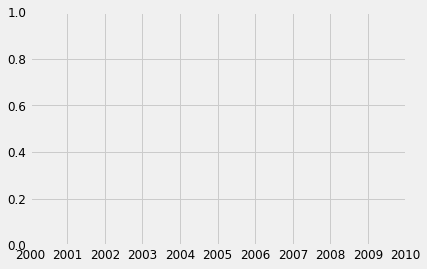

In [ ]:
plt.plot(appended['DHI_pred'])

# **Prophet Implementation**

In [ ]:
%matplotlib inline
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

imported pandas for data frame
imported FBphrophet for implimatation of prophet algo
matplotlib for ploting

In [ ]:
def prophetFormat(df):
  prophet = pd.DataFrame(df['DHI'].astype(float))
  #prophet.DHI.astype(float).resample('H').mean().dropna()
  #prophet.index.dtype
  prophet.reset_index(inplace=True)
  prophet.rename(columns = {'Date':'ds'}, inplace = True)
  prophet.rename(columns = {'DHI':'y'}, inplace = True)
  return prophet

resetting the index, so that the model doesnt include unrequired data tabs, like headings etc.
we choose one data column, on which its implemented coz its univariant and its renamed y
and time stamp is named as ds

In [ ]:
def view(df):
  ax = df.set_index('ds').plot(figsize = (12,8))
  ax.set_xlabel("Date")


visualization of data

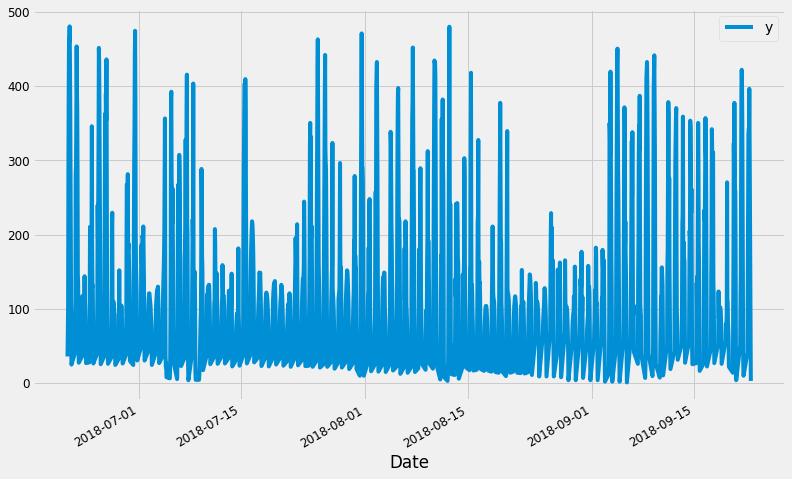

In [ ]:
prophet = prophetFormat(fl_arima)
view(prophet)

In [ ]:
prophet #1st sep = 1001	-1011 2nd sep = 1014-1024	3rd sep = 1027-1037

NameError: ignored

In [ ]:
prophet_model = Prophet(interval_width = 0.95)
prophet_model.fit(prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
future = prophet_model.make_future_dataframe(periods = 25, freq= 'H',)
future.tail(25)

ds
1269 2018-09-22 19:00:00
1270 2018-09-22 20:00:00
1271 2018-09-22 21:00:00
1272 2018-09-22 22:00:00
1273 2018-09-22 23:00:00
1274 2018-09-23 00:00:00
1275 2018-09-23 01:00:00
1276 2018-09-23 02:00:00
1277 2018-09-23 03:00:00
1278 2018-09-23 04:00:00
1279 2018-09-23 05:00:00
1280 2018-09-23 06:00:00
1281 2018-09-23 07:00:00
1282 2018-09-23 08:00:00
1283 2018-09-23 09:00:00
1284 2018-09-23 10:00:00
1285 2018-09-23 11:00:00
1286 2018-09-23 12:00:00
1287 2018-09-23 13:00:00
1288 2018-09-23 14:00:00
1289 2018-09-23 15:00:00
1290 2018-09-23 16:00:00
1291 2018-09-23 17:00:00
1292 2018-09-23 18:00:00
1293 2018-09-23 19:00:00

In [ ]:
a = [*range(1269,1281)]
future.drop(a,inplace=True)

In [ ]:
future.drop(1293, inplace=True)

In [ ]:
future  #1st sep = 1001	-1011 2nd sep = 1014-1024	3rd sep = 1027-1037 4th sep 1040:1050 5th sep 1053 6th 	1065 7th 1077

ds
0    2018-06-21 06:00:00
1    2018-06-21 07:00:00
2    2018-06-21 08:00:00
3    2018-06-21 09:00:00
4    2018-06-21 10:00:00
5    2018-06-21 11:00:00
6    2018-06-21 12:00:00
7    2018-06-21 13:00:00
8    2018-06-21 14:00:00
9    2018-06-21 15:00:00
10   2018-06-21 16:00:00
11   2018-06-21 17:00:00
12   2018-06-21 18:00:00
13   2018-06-21 19:00:00
14   2018-06-22 06:00:00
15   2018-06-22 07:00:00
16   2018-06-22 08:00:00
17   2018-06-22 09:00:00
18   2018-06-22 10:00:00
19   2018-06-22 11:00:00
20   2018-06-22 12:00:00
21   2018-06-22 13:00:00
22   2018-06-22 14:00:00
23   2018-06-22 15:00:00
24   2018-06-22 16:00:00
25   2018-06-22 17:00:00
26   2018-06-22 18:00:00
27   2018-06-22 19:00:00
28   2018-06-23 06:00:00
29   2018-06-23 07:00:00
30   2018-06-23 08:00:00
31   2018-06-23 09:00:00
32   2018-06-23 10:00:00
33   2018-06-23 11:00:00
34   2018-06-23 12:00:00
35   2018-06-23 13:00:00
36   2018-06-23 14:00:00
37   2018-06-23 15:00:00
38   2018-06-23 16:00:00
39   2018-06-23 17:00:00
40   2018-06-23 18:00:00
41   2018-06-23 19:00:00
42   2018-06-24 06:00:00
43   2018-06-24 07:00:00
44   2018-06-24 08:00:00
45   2018-06-24 09:00:00
46   2018-06-24 10:00:00
47   2018-06-24 11:00:00
48   2018-06-24 12:00:00
49   2018-06-24 13:00:00
50   2018-06-24 14:00:00
51   2018-06-24 15:00:00
52   2018-06-24 16:00:00
53   2018-06-24 17:00:00
54   2018-06-24 18:00:00
55   2018-06-24 19:00:00
56   2018-06-25 06:00:00
57   2018-06-25 07:00:00
58   2018-06-25 08:00:00
59   2018-06-25 09:00:00
60   2018-06-25 10:00:00
61   2018-06-25 11:00:00
62   2018-06-25 12:00:00
63   2018-06-25 13:00:00
64   2018-06-25 14:00:00
65   2018-06-25 15:00:00
66   2018-06-25 16:00:00
67   2018-06-25 17:00:00
68   2018-06-25 18:00:00
69   2018-06-25 19:00:00
70   2018-06-26 06:00:00
71   2018-06-26 07:00:00
72   2018-06-26 08:00:00
73   2018-06-26 09:00:00
74   2018-06-26 10:00:00
75   2018-06-26 11:00:00
76   2018-06-26 12:00:00
77   2018-06-26 13:00:00
78   2018-06-26 14:00:00
79   2018-06-26 15:00:00
80   2018-06-26 16:00:00
81   2018-06-26 17:00:00
82   2018-06-26 18:00:00
83   2018-06-26 19:00:00
84   2018-06-27 06:00:00
85   2018-06-27 07:00:00
86   2018-06-27 08:00:00
87   2018-06-27 09:00:00
88   2018-06-27 10:00:00
89   2018-06-27 11:00:00
90   2018-06-27 12:00:00
91   2018-06-27 13:00:00
92   2018-06-27 14:00:00
93   2018-06-27 15:00:00
94   2018-06-27 16:00:00
95   2018-06-27 17:00:00
96   2018-06-27 18:00:00
97   2018-06-27 19:00:00
98   2018-06-28 06:00:00
99   2018-06-28 07:00:00
100  2018-06-28 08:00:00
101  2018-06-28 09:00:00
102  2018-06-28 10:00:00
103  2018-06-28 11:00:00
104  2018-06-28 12:00:00
105  2018-06-28 13:00:00
106  2018-06-28 14:00:00
107  2018-06-28 15:00:00
108  2018-06-28 16:00:00
109  2018-06-28 17:00:00
110  2018-06-28 18:00:00
111  2018-06-28 19:00:00
112  2018-06-29 06:00:00
113  2018-06-29 07:00:00
114  2018-06-29 08:00:00
115  2018-06-29 09:00:00
116  2018-06-29 10:00:00
117  2018-06-29 11:00:00
118  2018-06-29 12:00:00
119  2018-06-29 13:00:00
120  2018-06-29 14:00:00
121  2018-06-29 15:00:00
122  2018-06-29 16:00:00
123  2018-06-29 17:00:00
124  2018-06-29 18:00:00
125  2018-06-29 19:00:00
126  2018-06-30 06:00:00
127  2018-06-30 07:00:00
128  2018-06-30 08:00:00
129  2018-06-30 09:00:00
130  2018-06-30 10:00:00
131  2018-06-30 11:00:00
132  2018-06-30 12:00:00
133  2018-06-30 13:00:00
134  2018-06-30 14:00:00
135  2018-06-30 15:00:00
136  2018-06-30 16:00:00
137  2018-06-30 17:00:00
138  2018-06-30 18:00:00
139  2018-06-30 19:00:00
140  2018-07-01 06:00:00
141  2018-07-01 07:00:00
142  2018-07-01 08:00:00
143  2018-07-01 09:00:00
144  2018-07-01 10:00:00
145  2018-07-01 11:00:00
146  2018-07-01 12:00:00
147  2018-07-01 13:00:00
148  2018-07-01 14:00:00
149  2018-07-01 15:00:00
150  2018-07-01 16:00:00
151  2018-07-01 17:00:00
152  2018-07-01 18:00:00
153  2018-07-01 19:00:00
154  2018-07-02 06:00:00
155  2018-07-02 07:00:00
156  2018-07-02 08:00:00
157  2018-07-02 09:00:00
158  2018-07-02 10:00:00
159  2018-07-02 11:00:

In [ ]:
forecast = prophet_model.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
1276 2018-09-23 14:00:00  239.166863  85.056301   385.699295
1277 2018-09-23 15:00:00  208.430259  65.717656   354.379947
1278 2018-09-23 16:00:00  170.692093  20.993381   328.960017
1279 2018-09-23 17:00:00  127.850674 -24.244530   271.889019
1280 2018-09-23 18:00:00  82.696009  -70.632220   218.399726

In [ ]:
forecast.iloc[1257:1269]['yhat']


1257    72.173819 
1258    121.856647
1259    169.680020
1260    209.086597
1261    235.922134
1262    247.587236
1263    243.527456
1264    225.779776
1265    197.938502
1266    163.086442
1267    123.143375
1268    81.021417 
Name: yhat, dtype: float64

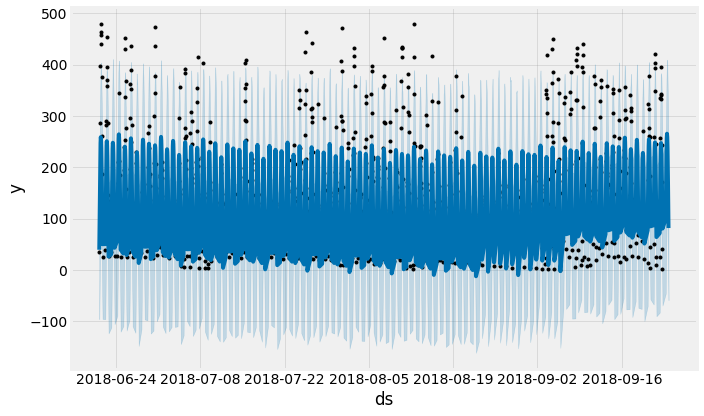

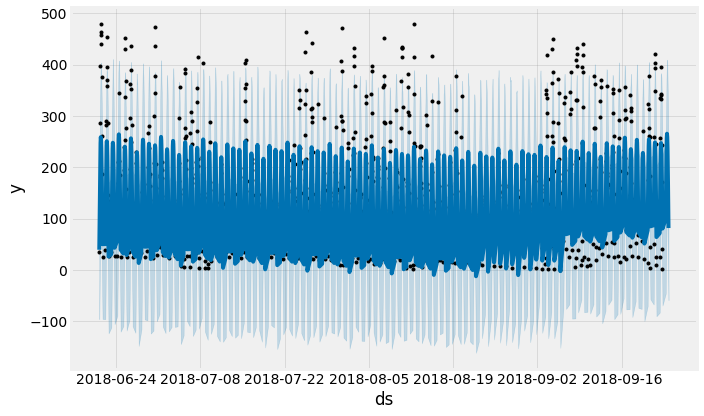

In [ ]:
prophet_model.plot(forecast, uncertainty=True)

## **1ST OF SEPTEMBER**

In [ ]:
 #1st sep = 1001	-1011 2nd sep = 1014-1024	3rd sep = 1027:1037
 prophet.iloc[1001:1011]['y']

1001    73.5 
1002    83.5 
1003    108.5
1004    125.5
1005    104.5
1006    182.5
1007    174.5
1008    104.5
1009    108.0
1010    83.5 
Name: y, dtype: float64

In [ ]:
forecast.iloc[1001:1011]['yhat']

1001    98.873759 
1002    146.697132
1003    186.103709
1004    212.939246
1005    224.604348
1006    220.544567
1007    202.796887
1008    174.955613
1009    140.103553
1010    100.160485
Name: yhat, dtype: float64

In [ ]:
diff = prophet.iloc[1001:1011]['y'] - forecast.iloc[1001:1011]['yhat']
mape = diff/prophet.iloc[1001:1011]['y']
mape_abs = adrak.abs()
mape_mean = lasun.mean()
mape_final = zeera*100
mape_final

52.04987100159296

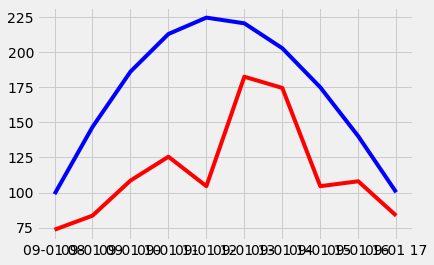

In [ ]:
plt.plot(prophet.iloc[1001:1011]['ds'].tolist(), forecast.iloc[1001:1011]['yhat'].tolist(),'b')
plt.plot(prophet.iloc[1001:1011]['ds'].tolist(), prophet.iloc[1001:1011]['y'].tolist(),'r')
plt.show()

## **2ND OF SEPTEMBER**

In [ ]:
#2nd sep = 1014:1024
prophet.iloc[1014:1024]['y']

1014    96.5 
1015    115.0
1016    107.5
1017    179.5
1018    157.5
1019    152.0
1020    137.5
1021    166.0
1022    136.0
1023    93.5 
Name: y, dtype: float64

In [ ]:
forecast.iloc[1014:1024]['yhat']

1014    125.202356
1015    171.368914
1016    208.848852
1017    233.512101
1018    242.786393
1019    236.147017
1020    215.662917
1021    184.962180
1022    147.162785
1023    104.220627
Name: yhat, dtype: float64

In [ ]:
diff = prophet.iloc[1014:1024]['y'] - forecast.iloc[1014:1024]['yhat']
mape_1 = diff/prophet.iloc[1014:1024]['y']
mape_abs_1 = adrak.abs()
mape_mean_1 = lasun.mean()
mape_final_1 = zeera*100
mape_final_1

52.04987100159296

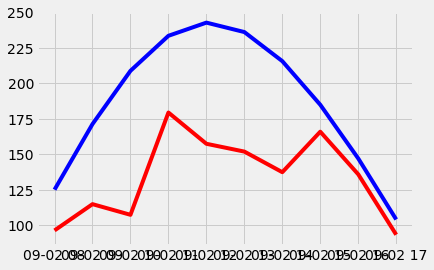

In [ ]:
plt.plot(prophet.iloc[1014:1024]['ds'].tolist(), forecast.iloc[1014:1024]['yhat'].tolist(),'b')
plt.plot(prophet.iloc[1014:1024]['ds'].tolist(), prophet.iloc[1014:1024]['y'].tolist(),'r')
plt.show()

## **3ND OF SEPTEMBER**

In [ ]:
prophet.iloc[1027:1037]['y']

1027    24.0 
1028    98.5 
1029    350.0
1030    342.5
1031    306.5
1032    419.5
1033    335.5
1034    261.0
1035    177.0
1036    128.0
Name: y, dtype: float64

In [ ]:
forecast.iloc[1027:1037]['yhat']

1027    100.352938
1028    146.697406
1029    184.663403
1030    210.111447
1031    220.456053
1032    215.155672
1033    196.259011
1034    167.370794
1035    131.582819
1036    90.822322 
Name: yhat, dtype: float64

In [ ]:
diff = prophet.iloc[1027:1037]['y'] - forecast.iloc[1027:1037]['yhat']
mape_2 = diff/prophet.iloc[1027:1037]['y']
mape_abs_2 = adrak.abs()
mape_mean_2 = lasun.mean()
mape_final_2 = zeera*100
mape_final_2

52.04987100159296

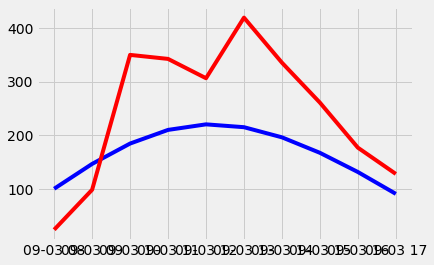

In [ ]:
plt.plot(prophet.iloc[1027:1037]['ds'].tolist(), forecast.iloc[1027:1037]['yhat'].tolist(),'b')
plt.plot(prophet.iloc[1027:1037]['ds'].tolist(), prophet.iloc[1027:1037]['y'].tolist(),'r')
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)

In [ ]:
def output(num1,num2):
  diff = prophet.iloc[num1:num2]['y'] - forecast.iloc[num1:num2]['yhat']
  adrak = diff/prophet.iloc[num1:num2]['y']
  lasun = adrak.abs()
  zeera = lasun.mean()
  onion = zeera*100
  print("MAPE VALUE:")
  print(onion)

  plt.plot(prophet.iloc[num1:num2]['ds'].tolist(), forecast.iloc[num1:num2]['yhat'].tolist(),'b')
  plt.plot(prophet.iloc[num1:num2]['ds'].tolist(), prophet.iloc[num1:num2]['y'].tolist(),'r')
  plt.legend()
  plt.rcParams["figure.figsize"] = (10,10)
  plt.show()

MAPE VALUE:
26.833499324202155


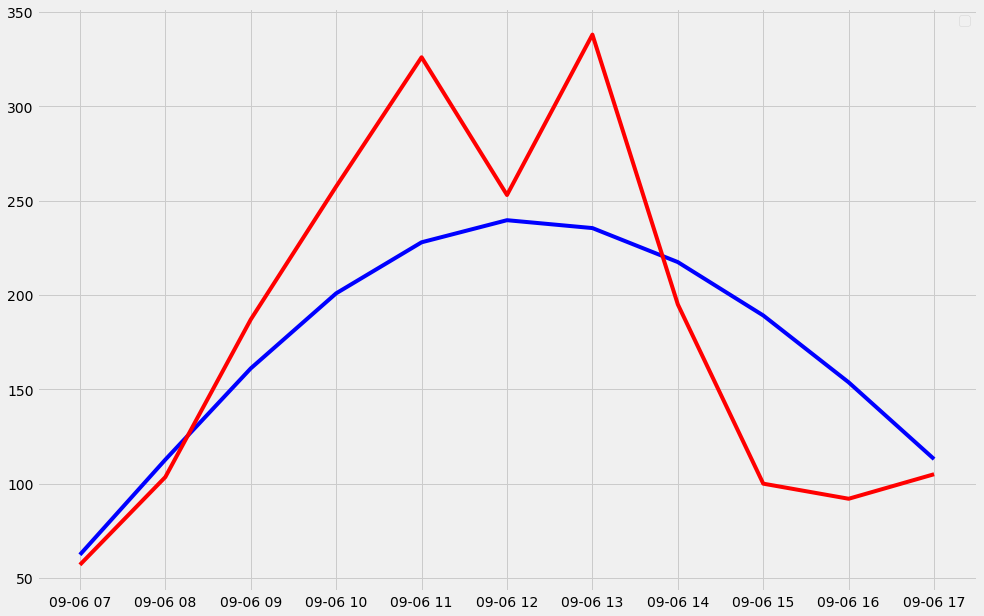

In [ ]:
#1st sep = 1001	-1011 2nd sep = 1014-1024	3rd sep = 1027-1037 4th sep 1040:1050 5th sep 1053 6th 	1065 7th 1077
output(1065,1076)

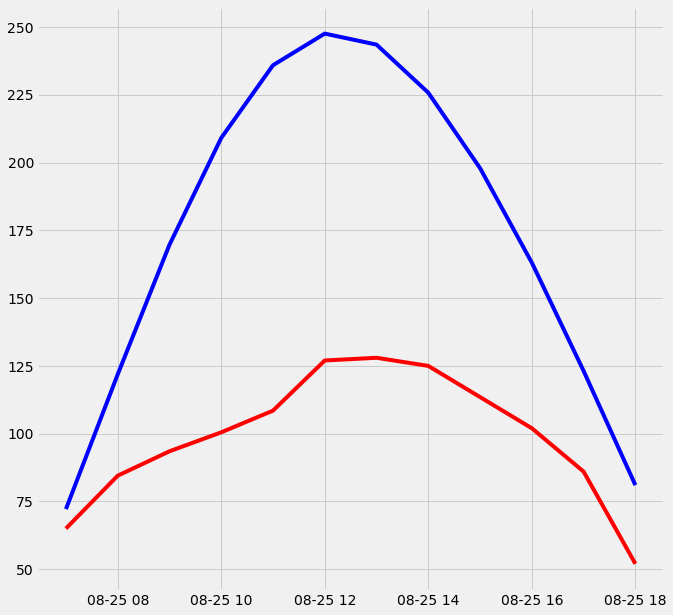

In [ ]:
plt.plot(prophet.iloc[909:921]['ds'].tolist(), forecast.iloc[1257:1269]['yhat'].tolist(),'b')
plt.plot(prophet.iloc[909:921]['ds'].tolist(), prophet.iloc[909:921]['y'].tolist(),'r')
plt.show()

In [ ]:
forecast.iloc[1257:1269]['yhat'].tolist()

[72.1738187555195,
 121.85664681068836,
 169.6800200059228,
 209.08659684560632,
 235.92213425823093,
 247.58723587040475,
 243.5274556275576,
 225.7797761167939,
 197.93850213919188,
 163.08644241800943,
 123.14337475313418,
 81.02141744832544]

In [ ]:
def mape(actual, pred):
  actual , pred = np.array(actual) , np.array(pred)
  return np.mean(np.abs((actual-pred)/actual)) *100
result = mape(prophet.iloc[1257:1269]['y'].tolist(),forecast.iloc[1257:1269]['yhat'].tolist())
print(result)

266.8676001948496


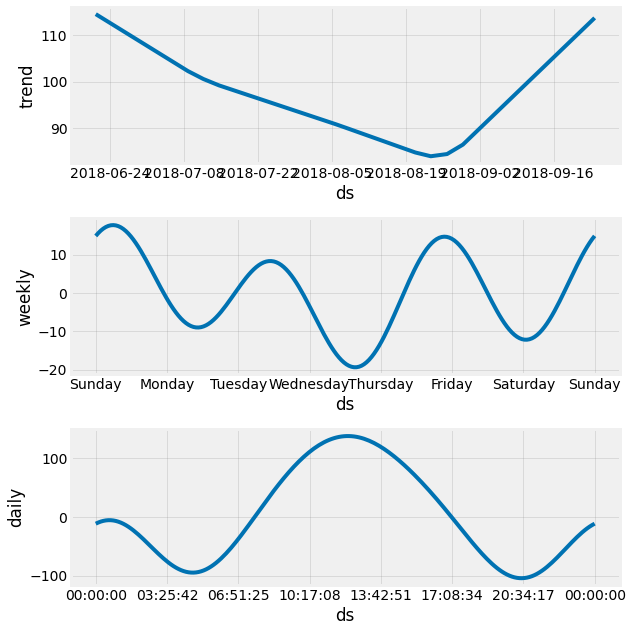

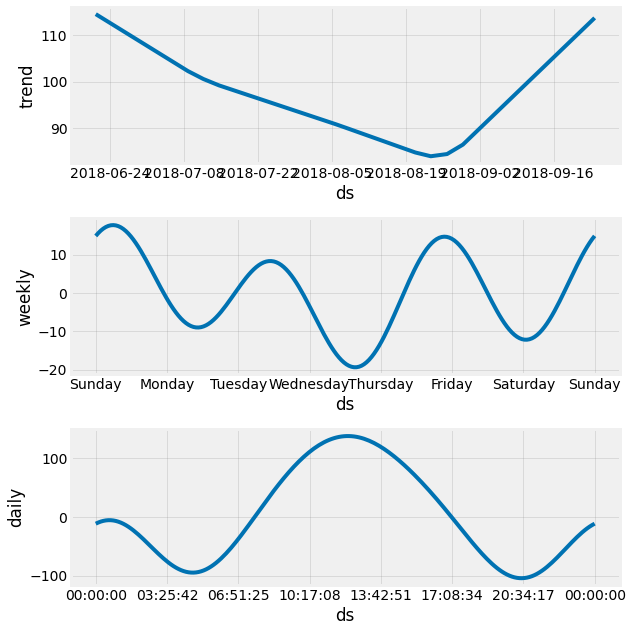

In [ ]:
prophet_model.plot_components(forecast)

## **Multivariate** **Models**

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


grangers_causation_matrix(DF, variables = DF.columns)

DHI_x  DNI_x  GHI_x  Dew Point_x  Wind Speed_x  \
DHI_y                1.0    0.0    0.0    0.0          0.0            
DNI_y                0.0    1.0    0.0    0.0          0.0            
GHI_y                0.0    0.0    1.0    0.0          0.0            
Dew Point_y          0.0    0.0    0.0    1.0          0.0            
Wind Speed_y         0.0    0.0    0.0    0.0          1.0            
Wind Direction_y     0.0    0.0    0.0    0.0          0.0            
Relative Humidity_y  0.0    0.0    0.0    0.0          0.0            
Temperature_y        0.0    0.0    0.0    0.0          0.0            

                     Wind Direction_x  Relative Humidity_x  Temperature_x  
DHI_y                0.0010            0.0                  0.0            
DNI_y                0.0000            0.0                  0.0            
GHI_y                0.0000            0.0                  0.0            
Dew Point_y          0.0000            0.0                  0.0            
Wind Speed_y         0.3507            0.0                  0.0            
Wind Direction_y     1.0000            0.0                  0.0            
Relative Humidity_y  0.0000            1.0                  0.0            
Temperature_y        0.0000            0.0                  1.0

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df.astype(float),-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    alpha=0.05
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)   =>   Signif  \n', '--'*40)
    for col, trace, cvt in zip(DF.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(DF)

Name   ::  Test Stat > C(95%)   =>   Signif  
 --------------------------------------------------------------------------------
DHI    ::  1650.46   > 143.6691  =>   True
DNI    ::  809.86    > 111.7797  =>   True
GHI    ::  441.58    > 83.9383   =>   True
Dew Point ::  285.2     > 60.0627   =>   True
Wind Speed ::  190.39    > 40.1749   =>   True
Wind Direction ::  101.1     > 24.2761   =>   True
Relative Humidity ::  35.05     > 12.3212   =>   True
Temperature ::  0.18      > 4.1296    =>   False


In [ ]:
DF.shape

(2546, 8)

In [ ]:
nobs = 44
DF_train, DF_test = DF[0:-nobs], DF[-nobs:]
print(DF_train.shape)
print(DF_test.shape)

(2502, 8)
(44, 8)


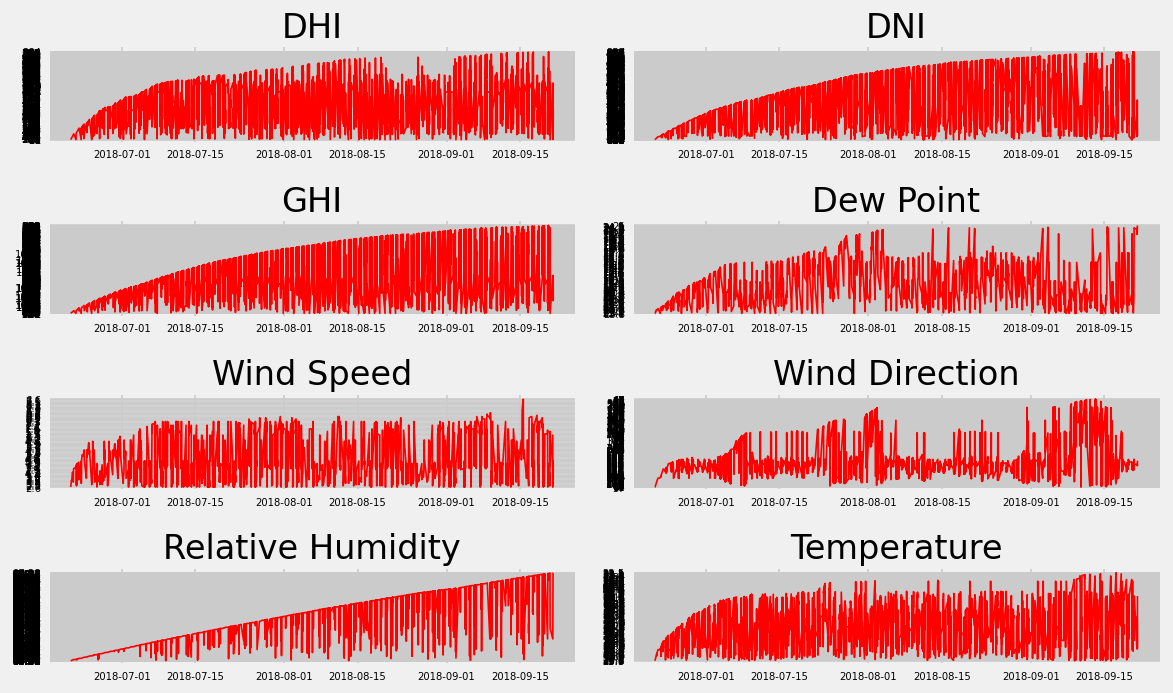

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = DF_train[DF_train.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(DF_train.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=1000, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = DF_test[DF_test.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(DF_test.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
# ADF Test on each column
for name, column in DF_train.iteritems():
    adfuller_test(column.astype(float), name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "DHI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8079
 No. Lags Chosen       = 24
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DNI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.9866
 No. Lags Chosen       = 27
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0015. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GHI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [ ]:
DF_train_diff =DF_train.astype(float).diff().dropna()

In [ ]:
for name, column in DF_train_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "DHI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -22.5327
 No. Lags Chosen       = 23
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DNI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.2475
 No. Lags Chosen       = 27
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GHI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [ ]:
model1 = VAR(DF_train_diff)
x = model1.select_order(maxlags=250)
x.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyboardInterrupt: ignored

In [ ]:
model = VAR(DF_train_diff)
for i in range(1,70):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag Order = 1
AIC :  26.323175268585214
BIC :  26.490907793697875
FPE :  270401983743.85867
HQIC:  26.38407009303984 

Lag Order = 2
AIC :  25.740313499890984
BIC :  26.05724661177316
FPE :  150965199290.14377
HQIC:  25.855377519207405 

Lag Order = 3
AIC :  25.45326268151598
BIC :  25.919495322883918
FPE :  113295810584.57516
HQIC:  25.622534021533212 

Lag Order = 4
AIC :  25.320110150104732
BIC :  25.935741370222416
FPE :  99172090130.14932
HQIC:  25.543626978913718 

Lag Order = 5
AIC :  25.137979734695634
BIC :  25.90310868953237
FPE :  82660143068.9123
HQIC:  25.41578026270291 

Lag Order = 6
AIC :  25.042837822569727
BIC :  25.957563774958007
FPE :  75159490406.96008
HQIC:  25.37496030256117 

Lag Order = 7
AIC :  24.95566002246056
BIC :  26.020082342254238
FPE :  68886338300.26126
HQIC:  25.342142749665275 

Lag Order = 8
AIC :  24.889945578926
BIC :  26.104163743158754
FPE :  64507036511.762115
HQIC:  25.33082689108034 

Lag Order = 9
AIC :  24.83838737212936
BIC :  26.2025009

In [ ]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,50):
    model = VAR(endog=DF_train_diff.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic

    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i

print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 33 BEST AIC: 23.662313429040054


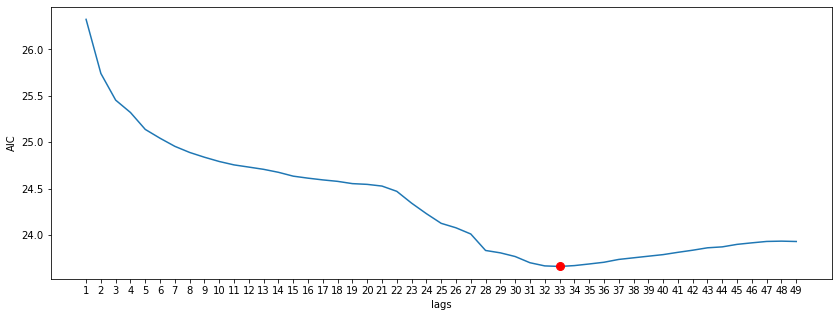

In [ ]:

### PLOT AICs ###

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,50
                                  ))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [ ]:
model_fitted = model.fit(33)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, Oct, 2020
Time:                     15:33:02
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    28.6541
Nobs:                     2468.00    HQIC:                   25.4757
Log likelihood:          -55094.8    FPE:                1.90239e+10
AIC:                      23.6623    Det(Omega_mle):     8.41286e+09
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.152475         0.811193           -0.188           0.851
L1.y1         -0.053572         0.030551           -1.754           0.080
L1.y2          0.011584         0.020228            0.573           0.567
L1.y3         -0.

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
def adjust(val, length= 6): return str(val).ljust(length)

for col, val in zip(DF_train.columns, out):
    print(adjust(col), ':', round(val, 2))

DHI    : 2.0
DNI    : 1.99
GHI    : 2.0
Dew Point : 1.98
Wind Speed : 2.0
Wind Direction : 2.0
Relative Humidity : 1.98
Temperature : 2.0


In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = DF_train_diff.values[-lag_order:]
forecast_input

33


array([[-1.e+01, -4.e+02, -1.e+02,  4.e-01, -7.e-01, -3.e+00,  1.e+01,
        -2.e+00],
       [-3.e+01, -2.e+02, -6.e+01,  0.e+00,  0.e+00, -1.e+00,  3.e+00,
        -5.e-01],
       [-2.e+00,  1.e+01, -2.e+00, -7.e-01,  0.e+00,  4.e+00,  1.e+01,
        -3.e+00],
       [ 8.e+00,  1.e+01,  1.e+01,  5.e-01,  3.e-01, -3.e+00,  0.e+00,
         5.e-01],
       [ 6.e+00, -2.e+01,  3.e+00,  1.e-01,  4.e-01,  1.e+00, -4.e+00,
         7.e-01],
       [ 3.e+01,  0.e+00,  3.e+01,  5.e-01,  4.e-01,  2.e+00, -1.e+00,
         7.e-01],
       [ 8.e+01,  1.e+01,  8.e+01,  0.e+00,  3.e-01,  5.e+00, -4.e+00,
         8.e-01],
       [ 2.e+01, -6.e+00,  1.e+01, -3.e-01,  3.e-01,  6.e+00, -5.e+00,
         7.e-01],
       [ 7.e+01,  2.e+01,  8.e+01,  0.e+00,  2.e-01,  1.e+00, -3.e+00,
         6.e-01],
       [ 1.e+02,  7.e+01,  1.e+02, -7.e-01,  1.e-01,  1.e+00, -6.e+00,
         6.e-01],
       [ 3.e+01,  3.e+00,  4.e+01,  0.e+00,  2.e-01,  1.e+00, -2.e+00,
         5.e-01],
       [-7.e+01, -7.e

In [ ]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=DF_test.index[-nobs:], columns = DF_train.columns + '_1d')
df_forecast

1                       DHI_1d     DNI_1d     GHI_1d  Dew Point_1d  \
Date                                                                 
2018-09-21 09:30:00  51.994259  33.163493  63.462464 -0.231325       
2018-09-21 10:00:00  31.701051  33.580733  61.441570 -0.317276       
2018-09-21 10:30:00  55.625430  25.081672  71.151798 -0.500235       
2018-09-21 11:00:00  40.733315  8.857300   46.664526  0.129195       
2018-09-21 11:30:00  9.508865  -0.019557   21.530809 -0.358924       
2018-09-21 12:00:00  1.586224   48.403408  71.527289  0.059793       
2018-09-21 12:30:00  10.098365 -1.192685   23.637818  0.061263       
2018-09-21 13:00:00  11.397636 -34.121108 -20.710436 -0.004047       
2018-09-21 13:30:00 -34.909948  68.858632  24.566407  0.330989       
2018-09-21 14:00:00 -23.121888  11.282947 -14.294505 -0.030889       
2018-09-21 14:30:00  19.425860 -31.010744 -34.354628  0.120677       
2018-09-21 15:00:00 -13.240238 -24.248219 -41.073529 -0.058298       
2018-09-21 15:30:00 -47.099058  23.852576 -31.870380 -0.110187       
2018-09-21 16:00:00 -25.391134  48.312818 -9.904368   0.304773       
2018-09-21 16:30:00 -24.743309 -35.208774 -68.064759 -0.277470       
2018-09-21 17:00:00 -25.134499 -68.660623 -80.702499 -0.157746       
2018-09-21 17:30:00 -29.777627  5.218479  -26.350081  0.338334       
2018-09-21 18:00:00 -22.027947 -25.409092 -45.963580 -0.133989       
2018-09-21 18:30:00 -5.910827  -56.483796 -47.624648  0.063771       
2018-09-22 06:30:00 -27.294277 -28.296951 -40.740313 -0.156283       
2018-09-22 07:00:00 -10.691741  6.233421  -6.008658   0.237739       
2018-09-22 07:30:00  10.232195  2.926610   20.671289  0.257483       
2018-09-22 08:00:00  32.623708 -45.857587  4.428989   0.215688       
2018-09-22 08:30:00  24.665979 -4.121516   14.066791  0.066750       
2018-09-22 09:00:00  10.544132  12.270712  33.895893 -0.162375       
2018-09-22 09:30:00  22.032409  3.768566   42.263179  0.049885       
2018-09-22 10:00:00  28.241054  12.765629  40.090260  0.134818       
2018-09-22 10:30:00  37.934439  31.314712  55.123667 -0.238477       
2018-09-22 11:00:00  21.904116  54.046913  61.538594 -0.377231       
2018-09-22 11:30:00  8.799121   49.153363  51.971079 -0.208503       
2018-09-22 12:00:00  15.455016  25.046229  46.257466 -0.230482       
2018-09-22 12:30:00  17.226594  10.894216  34.567209  0.039074       
2018-09-22 13:00:00  12.070029 -13.609983  14.536585 -0.317888       
2018-09-22 13:30:00 -10.787111  1.837341   5.397461   0.195069       
2018-09-22 14:00:00 -14.653057  23.372581  4.681701   0.108450       
2018-09-22 14:30:00 -11.174963  4.083824  -7.980325   0.005413       
2018-09-22 15:00:00 -10.655033 -6.811880  -27.322236  0.284631       
2018-09-22 15:30:00 -13.409992 -1.382241  -31.969759  0.072306       
2018-09-22 16:00:00 -29.279747  18.315468 -26.732674 -0.042957       
2018-09-22 16:30:00 -20.458018 -13.439650 -45.207858  0.054240       
2018-09-22 17:00:00 -8.981299  -37.835513 -58.600642  0.132461       
2018-09-22 17:30:00 -22.584111 -13.183796 -46.150692 -0.119666       
2018-09-22 18:00:00 -25.306775 -11.723807 -42.704905 -0.044893       
2018-09-22 18:30:00 -11.416666 -29.712393 -44.369934  0.026957       

1                    Wind Speed_1d  Wind Direction_1d  Relative Humidity_1d  \
Date                                                                          
2018-09-21 09:30:00  0.218017       14.487827         -3.984596               
2018-09-21 10:00:00  0.139107       3.855006          -5.254837               
2018-09-21 10:30:00  0.183973      -6.384354          -5.375538               
2018-09-21 11:00:00  0.065031       6.124960          -1.649870               
2018-09-21 11:30:00  0.208951       3.383380          -5.663874               
2018-09-21 12:00:00 -0.070396      -12.882577         -0.380341               
2018-09-21 12:30:00  0.073150      -2.069744          -0.994988               
2018-09-21 13:00:00 -0.002000       9.368758          -2.012074     

In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


In [ ]:
df_results = invert_transformation(DF_test.astype(float), df_forecast.astype(float), second_diff=False)
df_r = df_results.loc[:, ['DHI_forecast', 'DNI_forecast', 'GHI_forecast', 'Dew Point_forecast',
                   'Wind Speed_forecast', 'Wind Direction_forecast', 'Relative Humidity_forecast', 'Temperature_forecast']]

In [ ]:
df_r

1                    DHI_forecast  DNI_forecast  GHI_forecast  \
Date                                                            
2018-09-21 09:30:00  52.994259     33.163493     64.462464      
2018-09-21 10:00:00  84.695310     66.744226     125.904034     
2018-09-21 10:30:00  140.320740    91.825898     197.055832     
2018-09-21 11:00:00  181.054055    100.683198    243.720358     
2018-09-21 11:30:00  190.562920    100.663641    265.251167     
2018-09-21 12:00:00  192.149143    149.067049    336.778456     
2018-09-21 12:30:00  202.247508    147.874364    360.416273     
2018-09-21 13:00:00  213.645144    113.753256    339.705837     
2018-09-21 13:30:00  178.735196    182.611887    364.272244     
2018-09-21 14:00:00  155.613308    193.894834    349.977740     
2018-09-21 14:30:00  175.039168    162.884091    315.623111     
2018-09-21 15:00:00  161.798930    138.635871    274.549583     
2018-09-21 15:30:00  114.699872    162.488448    242.679203     
2018-09-21 16:00:00  89.308738     210.801266    232.774834     
2018-09-21 16:30:00  64.565429     175.592493    164.710076     
2018-09-21 17:00:00  39.430930     106.931870    84.007577      
2018-09-21 17:30:00  9.653302      112.150349    57.657496      
2018-09-21 18:00:00 -12.374645     86.741257     11.693916      
2018-09-21 18:30:00 -18.285472     30.257461    -35.930732      
2018-09-22 06:30:00 -45.579749     1.960510     -76.671045      
2018-09-22 07:00:00 -56.271489     8.193931     -82.679703      
2018-09-22 07:30:00 -46.039295     11.120541    -62.008414      
2018-09-22 08:00:00 -13.415586    -34.737045    -57.579426      
2018-09-22 08:30:00  11.250392    -38.858562    -43.512635      
2018-09-22 09:00:00  21.794524    -26.587850    -9.616742       
2018-09-22 09:30:00  43.826934    -22.819284     32.646437      
2018-09-22 10:00:00  72.067988    -10.053655     72.736697      
2018-09-22 10:30:00  110.002426    21.261057     127.860364     
2018-09-22 11:00:00  131.906542    75.307969     189.398959     
2018-09-22 11:30:00  140.705664    124.461332    241.370037     
2018-09-22 12:00:00  156.160680    149.507561    287.627503     
2018-09-22 12:30:00  173.387273    160.401777    322.194712     
2018-09-22 13:00:00  185.457302    146.791794    336.731297     
2018-09-22 13:30:00  174.670191    148.629135    342.128758     
2018-09-22 14:00:00  160.017134    172.001716    346.810459     
2018-09-22 14:30:00  148.842172    176.085540    338.830134     
2018-09-22 15:00:00  138.187139    169.273660    311.507899     
2018-09-22 15:30:00  124.777147    167.891419    279.538139     
2018-09-22 16:00:00  95.497400     186.206887    252.805466     
2018-09-22 16:30:00  75.039382     172.767237    207.597607     
2018-09-22 17:00:00  66.058083     134.931724    148.996965     
2018-09-22 17:30:00  43.473971     121.747928    102.846273     
2018-09-22 18:00:00  18.167196     110.024120    60.141368      
2018-09-22 18:30:00  6.750530      80.311727     15.771435      

1                    Dew Point_forecast  Wind Speed_forecast  \
Date                                                           
2018-09-21 09:30:00  18.768675           2.218017              
2018-09-21 10:00:00  18.451399           2.357123              
2018-09-21 10:30:00  17.951164           2.541096              
2018-09-21 11:00:00  18.080360           2.606127              
2018-09-21 11:30:00  17.721435           2.815079              
2018-09-21 12:00:00  17.781229           2.744682              
2018-09-21 12:30:00  17.842492           2.817832              
2018-09-21 13:00:00  17.838445           2.815832              
2018-09-21 13:30:00  18.169434           2.667495              
2018-09-21 14:00:00  18.138545           2.687978              
2018-09-21 14:30:00  18.259222           2.563201              
2018-09-21 15:00:00  18.200923           2.567960              
2018-09-21 15:30:00  18.090736           2.538238              
2018-09-21 16:00:00  18.395510           2.294788

TypeError: ignored

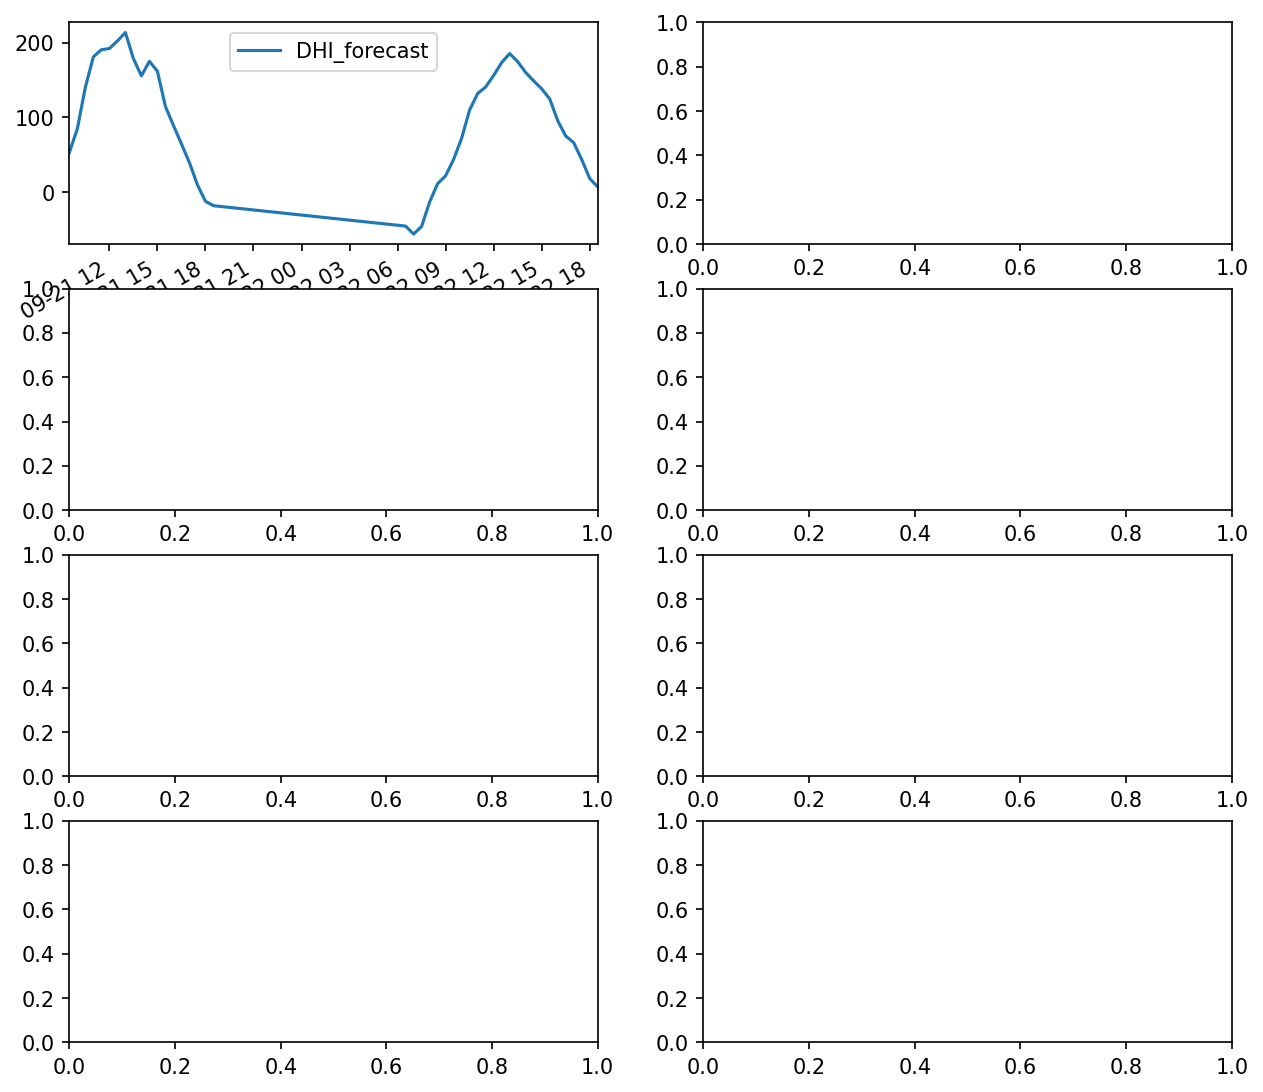

In [ ]:
fig, axes = plt.subplots(nrows=int(len(DF_test.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(DF_test.columns, axes.flatten())):
    df_r[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    DF_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


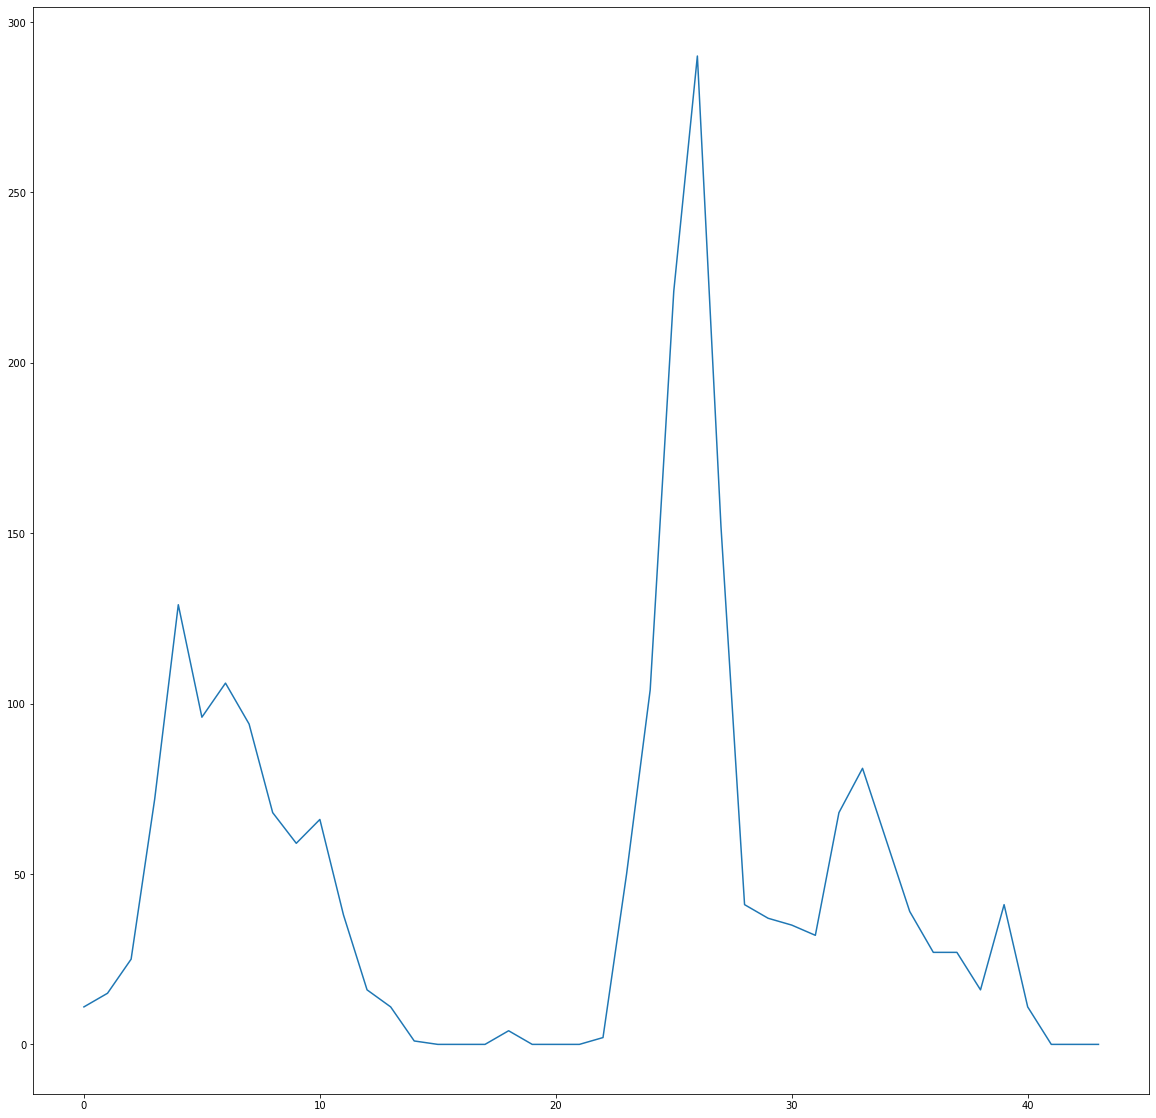

In [ ]:
plt.plot(DF_test["DNI"].astype(float).tolist()[0:48])

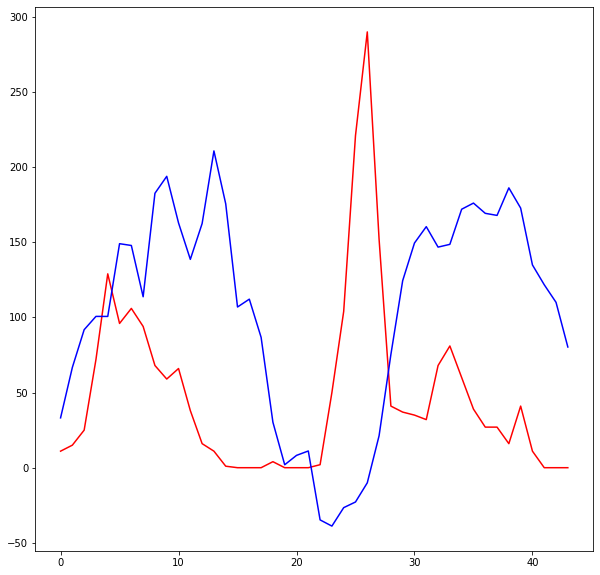

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(DF_test["DNI"].astype(float).tolist(), 'r')
plt.plot(df_r["DNI_forecast"].astype(float).tolist(), 'b')